## WGAN-GP Implementation

https://jonathan-hui.medium.com/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490

https://arxiv.org/pdf/1701.07875.pdf

https://towardsdatascience.com/demystified-wasserstein-gans-wgan-f835324899f4

In [9]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid", font_scale=1.2)

In [3]:
!unzip pokemons_archive.zip -d ./pokemons

Archive:  pokemons_archive.zip
  inflating: ./pokemons/images/Abomasnow/0.jpg  
  inflating: ./pokemons/images/Abomasnow/1.jpg  
  inflating: ./pokemons/images/Abomasnow/2.jpg  
  inflating: ./pokemons/images/Abomasnow/3.jpg  
  inflating: ./pokemons/images/Abra/0.jpg  
  inflating: ./pokemons/images/Abra/1.jpg  
  inflating: ./pokemons/images/Abra/2.jpg  
  inflating: ./pokemons/images/Abra/3.jpg  
  inflating: ./pokemons/images/Absol/0.jpg  
  inflating: ./pokemons/images/Absol/1.jpg  
  inflating: ./pokemons/images/Absol/2.jpg  
  inflating: ./pokemons/images/Absol/3.jpg  
  inflating: ./pokemons/images/Accelgor/0.jpg  
  inflating: ./pokemons/images/Accelgor/1.jpg  
  inflating: ./pokemons/images/Aegislash/0.jpg  
  inflating: ./pokemons/images/Aegislash/1.jpg  
  inflating: ./pokemons/images/Aegislash/2.jpg  
  inflating: ./pokemons/images/Aegislash/3.jpg  
  inflating: ./pokemons/images/Aerodactyl/0.jpg  
  inflating: ./pokemons/images/Aerodactyl/1.jpg  
  inflating: ./pokemons/i

In [1]:
root_dir = "./images"
stats = [[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]
image_size = 64
batch_size = 64
input_channels = 3
latent_size = 64

In [10]:
dataset = ImageFolder(root=root_dir, transform=tt.Compose([    
    tt.Resize((image_size, image_size)),
    tt.ToTensor(),
    tt.Normalize(*stats)
]))

In [11]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

##### Show Faces from Dataset

In [12]:
def denorm_image(tensor):
    for ch in range(input_channels):
        tensor[ch] = tensor[ch] * stats[1][ch] + stats[0][ch]

    return tensor

In [13]:
def show_images(batch: torch.Tensor, image_count: int = 25, denorm=True):
    indices = np.random.choice(batch.shape[0], min(batch.shape[0], image_count), replace=False)
    images = []

    for index in indices:
        if denorm:
            images.append(denorm_image(batch[index].cpu().detach()))
        else:
            images.append(batch[index].clone().cpu().detach())

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    grid = make_grid(torch.stack(images), nrow=min(5, min(batch.shape[0], image_count))).permute(1, 2, 0)
    ax.imshow(grid)

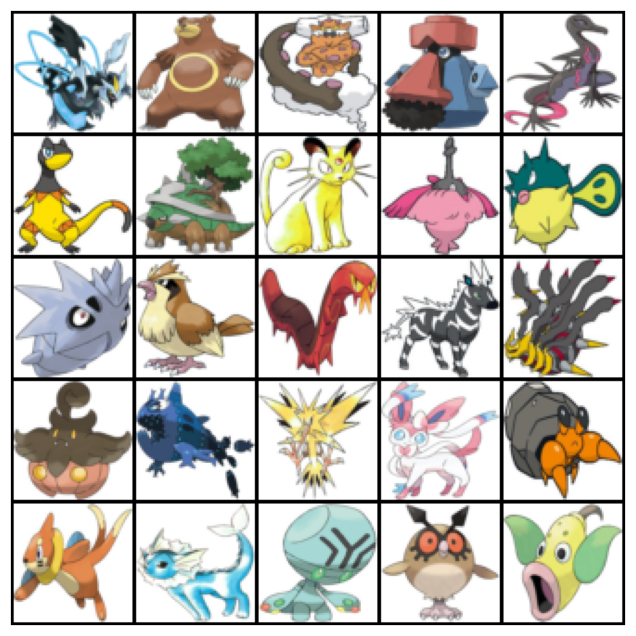

In [14]:
for (images, _) in dataloader:
    show_images(images)
    break

In [15]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [17]:
dataloader = DeviceDataLoader(dataloader, device)

## Model Architecture


In [18]:
from torchsummary import summary

![DCGAN Architecture](./model.png)

In [23]:
class PixelNorm(nn.Module):
    def __init__(self, eps=1e-8):
        super(PixelNorm, self).__init__()
        self.eps = eps
        
    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.eps)

def get_discriminator():
    return nn.Sequential(
        # in: image_size x image_size x input_channels
        nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),        
        PixelNorm(),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 64 x 32 x 32

        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
        PixelNorm(),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 128 x 16 x 16

        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
        PixelNorm(),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 256 x 8 x 8

        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
        PixelNorm(),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 512 x 4 x 4

        nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
        PixelNorm(),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 512 x 2 x 2

        nn.Conv2d(512, 1, kernel_size=2, stride=1, padding=0, bias=False),
        # out: 1 x 1 x 1
    )

discriminator = get_discriminator()

In [24]:
discriminator = to_device(discriminator, device)
summary(discriminator, (input_channels, image_size, image_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          3,072
├─PixelNorm: 1-2                         [-1, 64, 32, 32]          --
├─LeakyReLU: 1-3                         [-1, 64, 32, 32]          --
├─Conv2d: 1-4                            [-1, 128, 16, 16]         131,072
├─PixelNorm: 1-5                         [-1, 128, 16, 16]         --
├─LeakyReLU: 1-6                         [-1, 128, 16, 16]         --
├─Conv2d: 1-7                            [-1, 256, 8, 8]           524,288
├─PixelNorm: 1-8                         [-1, 256, 8, 8]           --
├─LeakyReLU: 1-9                         [-1, 256, 8, 8]           --
├─Conv2d: 1-10                           [-1, 512, 4, 4]           2,097,152
├─PixelNorm: 1-11                        [-1, 512, 4, 4]           --
├─LeakyReLU: 1-12                        [-1, 512, 4, 4]           --
├─Conv2d: 1-13                           [-1, 512, 2, 2]         

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          3,072
├─PixelNorm: 1-2                         [-1, 64, 32, 32]          --
├─LeakyReLU: 1-3                         [-1, 64, 32, 32]          --
├─Conv2d: 1-4                            [-1, 128, 16, 16]         131,072
├─PixelNorm: 1-5                         [-1, 128, 16, 16]         --
├─LeakyReLU: 1-6                         [-1, 128, 16, 16]         --
├─Conv2d: 1-7                            [-1, 256, 8, 8]           524,288
├─PixelNorm: 1-8                         [-1, 256, 8, 8]           --
├─LeakyReLU: 1-9                         [-1, 256, 8, 8]           --
├─Conv2d: 1-10                           [-1, 512, 4, 4]           2,097,152
├─PixelNorm: 1-11                        [-1, 512, 4, 4]           --
├─LeakyReLU: 1-12                        [-1, 512, 4, 4]           --
├─Conv2d: 1-13                           [-1, 512, 2, 2]         

In [25]:
def get_generator():
    return nn.Sequential(
        # in: latent_size x 1 x 1

        nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        # out: 512 x 4 x 4

        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        # out: 256 x 8 x 8

        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        # out: 128 x 16 x 16

        nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        # out: 128 x 32 x 32

        nn.ConvTranspose2d(128, input_channels, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
        # out: input_channels x 64 x 64
    )

generator = get_generator()

In [26]:
generator = to_device(generator, device)
summary(generator, (latent_size, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
├─ConvTranspose2d: 1-1                   [-1, 512, 4, 4]           524,288
├─BatchNorm2d: 1-2                       [-1, 512, 4, 4]           1,024
├─ReLU: 1-3                              [-1, 512, 4, 4]           --
├─ConvTranspose2d: 1-4                   [-1, 256, 8, 8]           2,097,152
├─BatchNorm2d: 1-5                       [-1, 256, 8, 8]           512
├─ReLU: 1-6                              [-1, 256, 8, 8]           --
├─ConvTranspose2d: 1-7                   [-1, 128, 16, 16]         524,288
├─BatchNorm2d: 1-8                       [-1, 128, 16, 16]         256
├─ReLU: 1-9                              [-1, 128, 16, 16]         --
├─ConvTranspose2d: 1-10                  [-1, 128, 32, 32]         262,144
├─BatchNorm2d: 1-11                      [-1, 128, 32, 32]         256
├─ReLU: 1-12                             [-1, 128, 32, 32]         --
├─ConvTranspose2d: 1-13                  [-1, 3, 64, 64] 

Layer (type:depth-idx)                   Output Shape              Param #
├─ConvTranspose2d: 1-1                   [-1, 512, 4, 4]           524,288
├─BatchNorm2d: 1-2                       [-1, 512, 4, 4]           1,024
├─ReLU: 1-3                              [-1, 512, 4, 4]           --
├─ConvTranspose2d: 1-4                   [-1, 256, 8, 8]           2,097,152
├─BatchNorm2d: 1-5                       [-1, 256, 8, 8]           512
├─ReLU: 1-6                              [-1, 256, 8, 8]           --
├─ConvTranspose2d: 1-7                   [-1, 128, 16, 16]         524,288
├─BatchNorm2d: 1-8                       [-1, 128, 16, 16]         256
├─ReLU: 1-9                              [-1, 128, 16, 16]         --
├─ConvTranspose2d: 1-10                  [-1, 128, 32, 32]         262,144
├─BatchNorm2d: 1-11                      [-1, 128, 32, 32]         256
├─ReLU: 1-12                             [-1, 128, 32, 32]         --
├─ConvTranspose2d: 1-13                  [-1, 3, 64, 64] 

#### Noise example

torch.Size([4, 3, 64, 64])


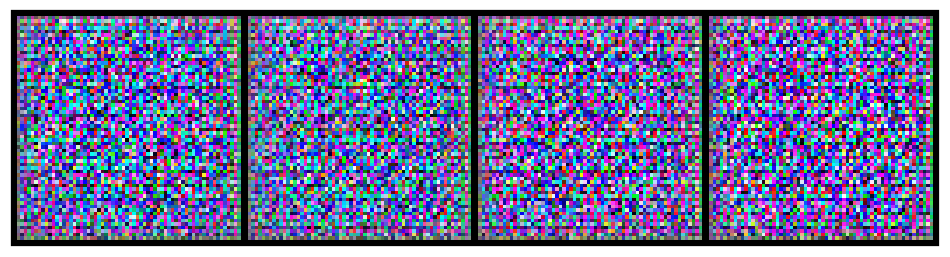

In [27]:
xb = torch.randn(4, latent_size, 1, 1).to(device)
fake_images = generator(xb).cpu()
print(fake_images.shape)
show_images(fake_images)

In [28]:
sample_dir = "wgan_generated"
os.makedirs(sample_dir, exist_ok=True)

In [29]:
checkpoints = "wgan_checkpoints"
os.makedirs(checkpoints, exist_ok=True)

In [30]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [31]:
def save_samples(index, latent_tensors, show=True, dir=sample_dir):
    fake_images = generator(latent_tensors)
    fake_fname = "generated-images-{0:0=4d}.png".format(index)
    save_image(denorm_image(fake_images), os.path.join(dir, fake_fname), nrow=8)
    print("Saving", fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

## Training

In [32]:
from datetime import datetime
from torch.autograd import grad

def gradient_penalty(netD, real_data, fake_data, LAMBDA=10):
    batch_size = real_data.size(0)
    # Sample Epsilon from uniform distribution
    eps = torch.rand(batch_size, 1).to(real_data.device)
    eps = eps.expand(batch_size, real_data.nelement()//batch_size).reshape(real_data.shape)
    
    # Interpolation between real data and fake data.
    interpolation = eps * real_data + (1 - eps) * fake_data
    
    # get logits for interpolated images
    interp_logits = netD(interpolation)
    grad_outputs = torch.ones_like(interp_logits)
    
    # Compute Gradients
    gradients = grad(
        outputs=interp_logits,
        inputs=interpolation,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
    )[0]
    
    # Compute and return Gradient Norm
    gradients = gradients.view(batch_size, -1)
    grad_norm = gradients.norm(2, 1)
    return torch.mean((grad_norm - 1) ** 2)

SAVE_EPOCH_INTERVAL = 1
CHECKPOINTS_INTERVAL = 10

def fit(model, epochs, optimizer):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []

    now_s = datetime.now().strftime("%Y.%m.%d-%H:%M:%S")

    # Dir for generated images    
    generated_dir = os.path.join(sample_dir, "examples_" + now_s)
    os.makedirs(generated_dir, exist_ok=True)

    # Dir for checkpoints
    cur_checkpoints = os.path.join(checkpoints, "chpt_" + now_s)
    os.makedirs(cur_checkpoints, exist_ok=True)    

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        for real_images, _ in tqdm(dataloader):            
            batch_size = real_images.size(0)

            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            loss_real = -model["discriminator"](real_images).mean()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            loss_fake = model["discriminator"](fake_images).mean()
            gp = gradient_penalty(model["discriminator"], real_images.detach(), fake_images)

            loss_d = loss_real + loss_fake + gp
            loss_d.backward()
            optimizer["discriminator"].step()

            loss_d_per_epoch.append(loss_d.item())

            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()                

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            loss_g = -model["discriminator"](fake_images).mean()
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))

        # Log losses & scores (last batch)
        print(
            "Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}".format(
                epoch + 1,
                epochs,
                losses_g[-1],
                losses_d[-1]
            )
        )
        
        # Save generated images
        if (epoch + 1) % SAVE_EPOCH_INTERVAL == 0:
            save_samples(epoch + 1, fixed_latent, show=False, dir=generated_dir)

        # Save checkpoints
        if (epoch + 1) % CHECKPOINTS_INTERVAL == 0:
            torch.save(model["discriminator"].state_dict(), os.path.join(cur_checkpoints, "discriminator_" + str(epoch + 1) + ".pt"))
            torch.save(model["generator"].state_dict(), os.path.join(cur_checkpoints, "generator_" + str(epoch + 1) + ".pt"))

    return losses_g, losses_d

In [33]:
model = {"discriminator": discriminator.to(device), "generator": generator.to(device)}

lr_d = 2e-4
lr_g = 2e-4
epochs = 1500

In [34]:
# Create optimizers
optimizer = {
    "discriminator": torch.optim.Adam(
        model["discriminator"].parameters(), lr=lr_d, betas=(0.5, 0.999), eps=0.00005
    ),
    "generator": torch.optim.Adam(
        model["generator"].parameters(), lr=lr_g, betas=(0.5, 0.999), eps=0.00005
    ),
}

In [35]:
history = fit(model, epochs, optimizer)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1/1500], loss_g: 22.8071, loss_d: -41.4498
Saving generated-images-0001.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [2/1500], loss_g: 5.1495, loss_d: -15.7153
Saving generated-images-0002.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [3/1500], loss_g: 15.5488, loss_d: -27.8562
Saving generated-images-0003.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [4/1500], loss_g: 16.6926, loss_d: -32.2075
Saving generated-images-0004.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [5/1500], loss_g: 23.3685, loss_d: -34.1012
Saving generated-images-0005.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [6/1500], loss_g: 0.8497, loss_d: -19.7286
Saving generated-images-0006.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [7/1500], loss_g: -11.9801, loss_d: -12.4798
Saving generated-images-0007.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [8/1500], loss_g: -5.8872, loss_d: -6.5633
Saving generated-images-0008.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [9/1500], loss_g: 25.5032, loss_d: -16.1810
Saving generated-images-0009.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [10/1500], loss_g: -5.0173, loss_d: -14.6467
Saving generated-images-0010.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [11/1500], loss_g: -9.3909, loss_d: -0.5872
Saving generated-images-0011.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [12/1500], loss_g: -49.7064, loss_d: -0.6353
Saving generated-images-0012.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [13/1500], loss_g: -51.1834, loss_d: 0.3562
Saving generated-images-0013.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [14/1500], loss_g: -28.7284, loss_d: -0.8248
Saving generated-images-0014.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [15/1500], loss_g: -16.2869, loss_d: -5.7606
Saving generated-images-0015.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [16/1500], loss_g: 13.0790, loss_d: -4.2879
Saving generated-images-0016.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [17/1500], loss_g: 14.3533, loss_d: -8.3424
Saving generated-images-0017.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [18/1500], loss_g: -10.3086, loss_d: -9.7975
Saving generated-images-0018.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [19/1500], loss_g: 2.9626, loss_d: -10.4911
Saving generated-images-0019.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [20/1500], loss_g: -1.4826, loss_d: -10.5826
Saving generated-images-0020.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [21/1500], loss_g: 14.8921, loss_d: -12.0706
Saving generated-images-0021.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [22/1500], loss_g: -9.4449, loss_d: -7.2518
Saving generated-images-0022.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [23/1500], loss_g: -20.4652, loss_d: -3.4916
Saving generated-images-0023.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [24/1500], loss_g: -0.2037, loss_d: -10.6140
Saving generated-images-0024.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [25/1500], loss_g: -31.5387, loss_d: -4.5513
Saving generated-images-0025.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [26/1500], loss_g: -20.7179, loss_d: -11.5045
Saving generated-images-0026.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [27/1500], loss_g: -1.6657, loss_d: -8.3111
Saving generated-images-0027.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [28/1500], loss_g: 38.5054, loss_d: -12.5269
Saving generated-images-0028.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [29/1500], loss_g: -24.0226, loss_d: -5.9562
Saving generated-images-0029.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [30/1500], loss_g: -47.8892, loss_d: -5.2347
Saving generated-images-0030.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [31/1500], loss_g: 9.4707, loss_d: 0.3902
Saving generated-images-0031.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [32/1500], loss_g: 20.9737, loss_d: -1.4124
Saving generated-images-0032.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [33/1500], loss_g: 19.4123, loss_d: -3.4294
Saving generated-images-0033.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [34/1500], loss_g: -1.1734, loss_d: -3.6515
Saving generated-images-0034.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [35/1500], loss_g: 37.7975, loss_d: -6.3650
Saving generated-images-0035.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [36/1500], loss_g: 63.6254, loss_d: -1.1846
Saving generated-images-0036.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [37/1500], loss_g: 16.8415, loss_d: -1.4515
Saving generated-images-0037.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [38/1500], loss_g: 17.6723, loss_d: -10.3301
Saving generated-images-0038.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [39/1500], loss_g: -2.5697, loss_d: -7.3148
Saving generated-images-0039.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [40/1500], loss_g: 4.8995, loss_d: -6.8249
Saving generated-images-0040.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [41/1500], loss_g: 23.5434, loss_d: -4.6051
Saving generated-images-0041.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [42/1500], loss_g: -12.6427, loss_d: -7.9096
Saving generated-images-0042.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [43/1500], loss_g: -25.5329, loss_d: -8.1622
Saving generated-images-0043.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [44/1500], loss_g: -29.7349, loss_d: -6.5832
Saving generated-images-0044.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [45/1500], loss_g: 16.1225, loss_d: -5.9454
Saving generated-images-0045.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [46/1500], loss_g: -14.4096, loss_d: -3.2335
Saving generated-images-0046.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [47/1500], loss_g: 27.2768, loss_d: -1.7031
Saving generated-images-0047.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [48/1500], loss_g: 55.0201, loss_d: -1.9582
Saving generated-images-0048.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [49/1500], loss_g: 31.1837, loss_d: -4.9117
Saving generated-images-0049.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [50/1500], loss_g: 50.0402, loss_d: 3.4362
Saving generated-images-0050.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [51/1500], loss_g: 50.7641, loss_d: 0.1957
Saving generated-images-0051.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [52/1500], loss_g: 50.4379, loss_d: -0.0474
Saving generated-images-0052.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [53/1500], loss_g: 48.8959, loss_d: 1.5660
Saving generated-images-0053.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [54/1500], loss_g: 50.2332, loss_d: -0.4505
Saving generated-images-0054.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [55/1500], loss_g: 50.4921, loss_d: 0.1830
Saving generated-images-0055.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [56/1500], loss_g: 52.4745, loss_d: 0.8629
Saving generated-images-0056.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [57/1500], loss_g: 51.8446, loss_d: -0.6637
Saving generated-images-0057.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [58/1500], loss_g: 58.9938, loss_d: 0.1175
Saving generated-images-0058.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [59/1500], loss_g: 63.7911, loss_d: 0.8020
Saving generated-images-0059.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [60/1500], loss_g: 69.0506, loss_d: -3.5815
Saving generated-images-0060.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [61/1500], loss_g: 71.1711, loss_d: -0.4000
Saving generated-images-0061.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [62/1500], loss_g: 52.5615, loss_d: 0.9407
Saving generated-images-0062.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [63/1500], loss_g: 59.6959, loss_d: -1.2178
Saving generated-images-0063.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [64/1500], loss_g: 61.0607, loss_d: -6.1626
Saving generated-images-0064.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [65/1500], loss_g: 73.9488, loss_d: -5.6952
Saving generated-images-0065.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [66/1500], loss_g: 66.4117, loss_d: -6.2539
Saving generated-images-0066.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [67/1500], loss_g: 66.3103, loss_d: -6.2022
Saving generated-images-0067.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [68/1500], loss_g: 78.6510, loss_d: -3.4348
Saving generated-images-0068.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [69/1500], loss_g: 71.5638, loss_d: -8.1338
Saving generated-images-0069.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [70/1500], loss_g: 12.9441, loss_d: -2.8125
Saving generated-images-0070.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [71/1500], loss_g: 32.7425, loss_d: -5.5657
Saving generated-images-0071.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [72/1500], loss_g: 35.8394, loss_d: -0.7018
Saving generated-images-0072.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [73/1500], loss_g: 46.9679, loss_d: -4.2985
Saving generated-images-0073.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [74/1500], loss_g: 18.1325, loss_d: -0.7317
Saving generated-images-0074.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [75/1500], loss_g: 4.5421, loss_d: 0.8129
Saving generated-images-0075.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [76/1500], loss_g: 7.5799, loss_d: -3.6057
Saving generated-images-0076.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [77/1500], loss_g: 29.2328, loss_d: -2.3276
Saving generated-images-0077.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [78/1500], loss_g: 7.8716, loss_d: -4.2230
Saving generated-images-0078.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [79/1500], loss_g: -28.9718, loss_d: -6.3093
Saving generated-images-0079.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [80/1500], loss_g: -28.4820, loss_d: -3.0153
Saving generated-images-0080.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [81/1500], loss_g: 46.1883, loss_d: -3.3334
Saving generated-images-0081.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [82/1500], loss_g: 63.0416, loss_d: -3.3705
Saving generated-images-0082.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [83/1500], loss_g: 44.6854, loss_d: -4.5045
Saving generated-images-0083.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [84/1500], loss_g: 49.5720, loss_d: -4.0072
Saving generated-images-0084.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [85/1500], loss_g: 41.3134, loss_d: -8.9510
Saving generated-images-0085.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [86/1500], loss_g: 8.9035, loss_d: -5.2961
Saving generated-images-0086.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [87/1500], loss_g: 7.5342, loss_d: -7.3346
Saving generated-images-0087.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [88/1500], loss_g: 23.6806, loss_d: -7.2030
Saving generated-images-0088.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [89/1500], loss_g: 31.0854, loss_d: -8.4605
Saving generated-images-0089.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [90/1500], loss_g: 43.9984, loss_d: -1.0442
Saving generated-images-0090.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [91/1500], loss_g: 18.3316, loss_d: -4.0140
Saving generated-images-0091.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [92/1500], loss_g: 60.3907, loss_d: -7.4773
Saving generated-images-0092.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [93/1500], loss_g: 30.2216, loss_d: 1.3507
Saving generated-images-0093.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [94/1500], loss_g: 25.1585, loss_d: 0.6371
Saving generated-images-0094.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [95/1500], loss_g: 23.1874, loss_d: 0.3432
Saving generated-images-0095.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [96/1500], loss_g: 20.3363, loss_d: 0.0722
Saving generated-images-0096.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [97/1500], loss_g: 18.4087, loss_d: -0.5989
Saving generated-images-0097.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [98/1500], loss_g: 3.4622, loss_d: -4.7980
Saving generated-images-0098.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [99/1500], loss_g: -54.0105, loss_d: -1.4814
Saving generated-images-0099.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [100/1500], loss_g: -41.5574, loss_d: -7.5200
Saving generated-images-0100.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [101/1500], loss_g: -19.6365, loss_d: -6.7015
Saving generated-images-0101.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [102/1500], loss_g: -23.6304, loss_d: -11.2864
Saving generated-images-0102.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [103/1500], loss_g: 3.8533, loss_d: -12.9672
Saving generated-images-0103.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [104/1500], loss_g: 24.0930, loss_d: -7.3320
Saving generated-images-0104.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [105/1500], loss_g: -4.1376, loss_d: -14.8703
Saving generated-images-0105.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [106/1500], loss_g: 22.7260, loss_d: -9.6459
Saving generated-images-0106.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [107/1500], loss_g: -0.2941, loss_d: -14.4771
Saving generated-images-0107.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [108/1500], loss_g: 11.5428, loss_d: -10.0256
Saving generated-images-0108.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [109/1500], loss_g: 58.5038, loss_d: -7.8714
Saving generated-images-0109.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [110/1500], loss_g: -6.6938, loss_d: -13.5055
Saving generated-images-0110.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [111/1500], loss_g: 14.1758, loss_d: -4.8017
Saving generated-images-0111.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [112/1500], loss_g: -16.7111, loss_d: -7.5756
Saving generated-images-0112.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [113/1500], loss_g: 9.2411, loss_d: -6.9133
Saving generated-images-0113.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [114/1500], loss_g: 20.9464, loss_d: -9.0197
Saving generated-images-0114.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [115/1500], loss_g: 52.0620, loss_d: -8.2818
Saving generated-images-0115.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [116/1500], loss_g: 48.3971, loss_d: 3.1431
Saving generated-images-0116.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [117/1500], loss_g: 28.2517, loss_d: 0.1413
Saving generated-images-0117.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [118/1500], loss_g: 29.3756, loss_d: 0.6947
Saving generated-images-0118.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [119/1500], loss_g: 29.0649, loss_d: 0.2206
Saving generated-images-0119.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [120/1500], loss_g: 29.9788, loss_d: 0.2265
Saving generated-images-0120.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [121/1500], loss_g: 33.8217, loss_d: 0.7010
Saving generated-images-0121.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [122/1500], loss_g: 29.7458, loss_d: 0.7011
Saving generated-images-0122.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [123/1500], loss_g: 27.1869, loss_d: 0.9548
Saving generated-images-0123.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [124/1500], loss_g: 28.0493, loss_d: 0.8157
Saving generated-images-0124.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [125/1500], loss_g: 18.1347, loss_d: 0.0492
Saving generated-images-0125.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [126/1500], loss_g: 27.6442, loss_d: -1.1857
Saving generated-images-0126.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [127/1500], loss_g: 17.2836, loss_d: -0.6745
Saving generated-images-0127.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [128/1500], loss_g: 46.8257, loss_d: -1.8741
Saving generated-images-0128.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [129/1500], loss_g: 28.5473, loss_d: 0.0059
Saving generated-images-0129.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [130/1500], loss_g: 19.3011, loss_d: -2.3277
Saving generated-images-0130.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [131/1500], loss_g: 5.9705, loss_d: -1.9854
Saving generated-images-0131.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [132/1500], loss_g: 19.5249, loss_d: -5.0457
Saving generated-images-0132.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [133/1500], loss_g: 52.0834, loss_d: -1.6006
Saving generated-images-0133.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [134/1500], loss_g: 23.4299, loss_d: -5.8050
Saving generated-images-0134.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [135/1500], loss_g: 34.6628, loss_d: -2.0785
Saving generated-images-0135.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [136/1500], loss_g: 21.9727, loss_d: -0.9583
Saving generated-images-0136.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [137/1500], loss_g: 24.5037, loss_d: -0.7137
Saving generated-images-0137.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [138/1500], loss_g: 12.1262, loss_d: -2.2355
Saving generated-images-0138.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [139/1500], loss_g: -32.1028, loss_d: -0.6851
Saving generated-images-0139.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [140/1500], loss_g: -3.4402, loss_d: -4.9801
Saving generated-images-0140.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [141/1500], loss_g: 44.3504, loss_d: -5.8959
Saving generated-images-0141.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [142/1500], loss_g: -20.0550, loss_d: -4.5236
Saving generated-images-0142.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [143/1500], loss_g: 32.6051, loss_d: -4.0163
Saving generated-images-0143.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [144/1500], loss_g: 45.9484, loss_d: -4.4429
Saving generated-images-0144.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [145/1500], loss_g: 25.2994, loss_d: -5.3731
Saving generated-images-0145.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [146/1500], loss_g: 68.6186, loss_d: -4.0914
Saving generated-images-0146.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [147/1500], loss_g: 68.5263, loss_d: -5.2493
Saving generated-images-0147.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [148/1500], loss_g: 7.7261, loss_d: -6.1113
Saving generated-images-0148.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [149/1500], loss_g: -2.6474, loss_d: -6.5033
Saving generated-images-0149.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [150/1500], loss_g: 57.4763, loss_d: -4.8653
Saving generated-images-0150.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [151/1500], loss_g: 14.2022, loss_d: -5.7812
Saving generated-images-0151.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [152/1500], loss_g: 7.6202, loss_d: -4.7562
Saving generated-images-0152.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [153/1500], loss_g: 27.7921, loss_d: -3.7711
Saving generated-images-0153.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [154/1500], loss_g: -19.4894, loss_d: -6.4415
Saving generated-images-0154.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [155/1500], loss_g: -35.4817, loss_d: -4.6340
Saving generated-images-0155.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [156/1500], loss_g: -38.2486, loss_d: -5.6830
Saving generated-images-0156.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [157/1500], loss_g: 29.4843, loss_d: -6.7664
Saving generated-images-0157.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [158/1500], loss_g: 21.7931, loss_d: -6.2568
Saving generated-images-0158.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [159/1500], loss_g: 6.2915, loss_d: -3.2548
Saving generated-images-0159.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [160/1500], loss_g: 36.2919, loss_d: -4.0566
Saving generated-images-0160.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [161/1500], loss_g: 15.8264, loss_d: -5.6592
Saving generated-images-0161.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [162/1500], loss_g: -23.9494, loss_d: -6.3780
Saving generated-images-0162.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [163/1500], loss_g: 20.9243, loss_d: -5.6861
Saving generated-images-0163.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [164/1500], loss_g: 62.6267, loss_d: -6.7566
Saving generated-images-0164.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [165/1500], loss_g: 38.4041, loss_d: -6.6798
Saving generated-images-0165.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [166/1500], loss_g: 21.6053, loss_d: -4.2371
Saving generated-images-0166.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [167/1500], loss_g: 20.0163, loss_d: -6.7780
Saving generated-images-0167.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [168/1500], loss_g: 46.8783, loss_d: -2.1718
Saving generated-images-0168.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [169/1500], loss_g: 17.3319, loss_d: -4.0654
Saving generated-images-0169.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [170/1500], loss_g: 28.4375, loss_d: -3.6866
Saving generated-images-0170.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [171/1500], loss_g: 24.0219, loss_d: -4.0558
Saving generated-images-0171.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [172/1500], loss_g: -10.0403, loss_d: -3.5837
Saving generated-images-0172.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [173/1500], loss_g: -66.8331, loss_d: -4.5050
Saving generated-images-0173.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [174/1500], loss_g: 11.3791, loss_d: -5.6380
Saving generated-images-0174.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [175/1500], loss_g: 16.7174, loss_d: -4.5201
Saving generated-images-0175.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [176/1500], loss_g: 31.2507, loss_d: -3.1898
Saving generated-images-0176.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [177/1500], loss_g: 16.0395, loss_d: -3.8853
Saving generated-images-0177.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [178/1500], loss_g: 51.3005, loss_d: -4.7392
Saving generated-images-0178.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [179/1500], loss_g: 64.0338, loss_d: -3.4438
Saving generated-images-0179.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [180/1500], loss_g: 41.5271, loss_d: -4.9353
Saving generated-images-0180.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [181/1500], loss_g: -14.9944, loss_d: -2.5161
Saving generated-images-0181.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [182/1500], loss_g: 1.1305, loss_d: -4.0073
Saving generated-images-0182.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [183/1500], loss_g: 47.8920, loss_d: -3.0677
Saving generated-images-0183.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [184/1500], loss_g: 62.0001, loss_d: -3.0778
Saving generated-images-0184.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [185/1500], loss_g: 6.7389, loss_d: -3.3225
Saving generated-images-0185.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [186/1500], loss_g: 43.1284, loss_d: -4.5328
Saving generated-images-0186.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [187/1500], loss_g: 30.2898, loss_d: -3.2445
Saving generated-images-0187.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [188/1500], loss_g: 8.9959, loss_d: -3.4870
Saving generated-images-0188.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [189/1500], loss_g: 47.5654, loss_d: -2.7953
Saving generated-images-0189.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [190/1500], loss_g: 16.3522, loss_d: -3.6950
Saving generated-images-0190.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [191/1500], loss_g: -6.9415, loss_d: -3.8134
Saving generated-images-0191.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [192/1500], loss_g: 9.4441, loss_d: -4.9218
Saving generated-images-0192.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [193/1500], loss_g: 59.8608, loss_d: -5.0541
Saving generated-images-0193.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [194/1500], loss_g: 60.0839, loss_d: -2.5026
Saving generated-images-0194.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [195/1500], loss_g: 1.6247, loss_d: -3.9366
Saving generated-images-0195.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [196/1500], loss_g: 35.6685, loss_d: -1.8914
Saving generated-images-0196.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [197/1500], loss_g: 82.4068, loss_d: -1.8082
Saving generated-images-0197.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [198/1500], loss_g: 92.9158, loss_d: -1.7580
Saving generated-images-0198.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [199/1500], loss_g: 71.4611, loss_d: -2.4618
Saving generated-images-0199.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [200/1500], loss_g: 46.4452, loss_d: -3.1453
Saving generated-images-0200.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [201/1500], loss_g: 47.7240, loss_d: -0.4301
Saving generated-images-0201.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [202/1500], loss_g: 40.5423, loss_d: -0.0950
Saving generated-images-0202.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [203/1500], loss_g: 28.9356, loss_d: -0.7037
Saving generated-images-0203.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [204/1500], loss_g: 20.2911, loss_d: -1.5422
Saving generated-images-0204.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [205/1500], loss_g: 29.9121, loss_d: -1.4000
Saving generated-images-0205.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [206/1500], loss_g: 41.3998, loss_d: -1.4711
Saving generated-images-0206.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [207/1500], loss_g: 9.9314, loss_d: -1.2074
Saving generated-images-0207.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [208/1500], loss_g: -9.4157, loss_d: -1.7370
Saving generated-images-0208.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [209/1500], loss_g: -24.0655, loss_d: -2.8222
Saving generated-images-0209.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [210/1500], loss_g: -15.8814, loss_d: -1.3251
Saving generated-images-0210.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [211/1500], loss_g: -13.2606, loss_d: -0.9082
Saving generated-images-0211.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [212/1500], loss_g: -4.2000, loss_d: -1.9601
Saving generated-images-0212.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [213/1500], loss_g: 13.3791, loss_d: -0.6221
Saving generated-images-0213.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [214/1500], loss_g: 16.7537, loss_d: -2.1832
Saving generated-images-0214.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [215/1500], loss_g: -26.6835, loss_d: -1.7573
Saving generated-images-0215.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [216/1500], loss_g: -14.5538, loss_d: -3.0864
Saving generated-images-0216.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [217/1500], loss_g: -50.6504, loss_d: 0.6843
Saving generated-images-0217.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [218/1500], loss_g: -53.3024, loss_d: -0.6474
Saving generated-images-0218.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [219/1500], loss_g: -16.6568, loss_d: -3.0212
Saving generated-images-0219.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [220/1500], loss_g: 3.5148, loss_d: -1.9280
Saving generated-images-0220.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [221/1500], loss_g: 0.0594, loss_d: -1.1986
Saving generated-images-0221.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [222/1500], loss_g: 48.9504, loss_d: -3.0942
Saving generated-images-0222.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [223/1500], loss_g: 55.1095, loss_d: -1.1479
Saving generated-images-0223.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [224/1500], loss_g: 71.3911, loss_d: -3.2718
Saving generated-images-0224.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [225/1500], loss_g: 20.6727, loss_d: -0.4994
Saving generated-images-0225.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [226/1500], loss_g: 3.2089, loss_d: -2.5659
Saving generated-images-0226.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [227/1500], loss_g: 10.6403, loss_d: -1.9634
Saving generated-images-0227.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [228/1500], loss_g: 47.0994, loss_d: -2.5014
Saving generated-images-0228.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [229/1500], loss_g: 39.6792, loss_d: -3.9043
Saving generated-images-0229.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [230/1500], loss_g: 30.5942, loss_d: -4.1828
Saving generated-images-0230.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [231/1500], loss_g: 0.9945, loss_d: -1.0298
Saving generated-images-0231.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [232/1500], loss_g: -3.6435, loss_d: -2.1913
Saving generated-images-0232.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [233/1500], loss_g: 47.1673, loss_d: -1.7166
Saving generated-images-0233.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [234/1500], loss_g: 27.3290, loss_d: -0.1348
Saving generated-images-0234.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [235/1500], loss_g: 18.9866, loss_d: -4.6655
Saving generated-images-0235.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [236/1500], loss_g: 29.7545, loss_d: -0.0627
Saving generated-images-0236.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [237/1500], loss_g: 84.4565, loss_d: -2.6549
Saving generated-images-0237.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [238/1500], loss_g: 55.4180, loss_d: -4.2965
Saving generated-images-0238.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [239/1500], loss_g: -21.7173, loss_d: -2.9025
Saving generated-images-0239.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [240/1500], loss_g: 11.6621, loss_d: -2.4175
Saving generated-images-0240.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [241/1500], loss_g: -21.8528, loss_d: -3.0839
Saving generated-images-0241.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [242/1500], loss_g: 33.5554, loss_d: -2.0180
Saving generated-images-0242.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [243/1500], loss_g: -6.6016, loss_d: -1.2864
Saving generated-images-0243.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [244/1500], loss_g: 41.5739, loss_d: 5.2355
Saving generated-images-0244.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [245/1500], loss_g: 14.4255, loss_d: 0.7054
Saving generated-images-0245.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [246/1500], loss_g: 14.5151, loss_d: 0.8081
Saving generated-images-0246.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [247/1500], loss_g: 15.6352, loss_d: 0.7401
Saving generated-images-0247.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [248/1500], loss_g: 18.4573, loss_d: 0.4209
Saving generated-images-0248.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [249/1500], loss_g: 20.8252, loss_d: 0.2932
Saving generated-images-0249.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [250/1500], loss_g: 18.9729, loss_d: -0.3545
Saving generated-images-0250.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [251/1500], loss_g: 21.7954, loss_d: -0.1991
Saving generated-images-0251.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [252/1500], loss_g: 17.7461, loss_d: -0.5030
Saving generated-images-0252.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [253/1500], loss_g: 16.6446, loss_d: -1.6505
Saving generated-images-0253.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [254/1500], loss_g: 4.8998, loss_d: -0.6403
Saving generated-images-0254.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [255/1500], loss_g: 12.6354, loss_d: -0.4390
Saving generated-images-0255.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [256/1500], loss_g: 17.5608, loss_d: -2.0207
Saving generated-images-0256.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [257/1500], loss_g: 12.0424, loss_d: -0.2548
Saving generated-images-0257.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [258/1500], loss_g: 13.7338, loss_d: -0.7204
Saving generated-images-0258.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [259/1500], loss_g: 8.7324, loss_d: -3.9131
Saving generated-images-0259.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [260/1500], loss_g: -25.9820, loss_d: -0.9260
Saving generated-images-0260.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [261/1500], loss_g: -5.7073, loss_d: -0.7980
Saving generated-images-0261.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [262/1500], loss_g: 18.3381, loss_d: -1.7573
Saving generated-images-0262.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [263/1500], loss_g: 18.9092, loss_d: -0.5042
Saving generated-images-0263.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [264/1500], loss_g: 19.2114, loss_d: -2.3734
Saving generated-images-0264.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [265/1500], loss_g: 23.7692, loss_d: -0.6204
Saving generated-images-0265.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [266/1500], loss_g: 43.3340, loss_d: -2.2455
Saving generated-images-0266.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [267/1500], loss_g: 48.3762, loss_d: -0.9903
Saving generated-images-0267.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [268/1500], loss_g: 56.0382, loss_d: -2.0933
Saving generated-images-0268.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [269/1500], loss_g: 53.8852, loss_d: 1.1923
Saving generated-images-0269.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [270/1500], loss_g: 51.4437, loss_d: -0.1005
Saving generated-images-0270.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [271/1500], loss_g: 57.7304, loss_d: -1.3983
Saving generated-images-0271.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [272/1500], loss_g: 53.4786, loss_d: -1.5506
Saving generated-images-0272.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [273/1500], loss_g: 36.9656, loss_d: -1.1938
Saving generated-images-0273.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [274/1500], loss_g: 48.3401, loss_d: -1.7823
Saving generated-images-0274.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [275/1500], loss_g: 38.3785, loss_d: -1.7075
Saving generated-images-0275.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [276/1500], loss_g: 39.7321, loss_d: -1.8593
Saving generated-images-0276.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [277/1500], loss_g: 46.9237, loss_d: -1.5401
Saving generated-images-0277.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [278/1500], loss_g: 33.4358, loss_d: -2.6353
Saving generated-images-0278.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [279/1500], loss_g: 1.2077, loss_d: -1.7140
Saving generated-images-0279.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [280/1500], loss_g: -13.4020, loss_d: -3.0032
Saving generated-images-0280.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [281/1500], loss_g: 38.5737, loss_d: -0.1732
Saving generated-images-0281.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [282/1500], loss_g: 75.6072, loss_d: -2.1483
Saving generated-images-0282.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [283/1500], loss_g: 70.9474, loss_d: -1.7579
Saving generated-images-0283.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [284/1500], loss_g: 71.4912, loss_d: -2.5370
Saving generated-images-0284.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [285/1500], loss_g: 54.8769, loss_d: -1.9318
Saving generated-images-0285.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [286/1500], loss_g: 45.5570, loss_d: -0.2702
Saving generated-images-0286.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [287/1500], loss_g: 54.4713, loss_d: -2.6313
Saving generated-images-0287.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [288/1500], loss_g: 23.2636, loss_d: -2.1759
Saving generated-images-0288.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [289/1500], loss_g: 16.9687, loss_d: -0.8391
Saving generated-images-0289.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [290/1500], loss_g: 37.8087, loss_d: -0.0781
Saving generated-images-0290.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [291/1500], loss_g: 34.7615, loss_d: -1.9751
Saving generated-images-0291.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [292/1500], loss_g: 2.6823, loss_d: -1.2860
Saving generated-images-0292.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [293/1500], loss_g: -5.7638, loss_d: -0.3375
Saving generated-images-0293.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [294/1500], loss_g: 9.7145, loss_d: -1.3354
Saving generated-images-0294.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [295/1500], loss_g: 17.3644, loss_d: -1.1412
Saving generated-images-0295.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [296/1500], loss_g: 22.7602, loss_d: -2.5794
Saving generated-images-0296.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [297/1500], loss_g: -22.1859, loss_d: -1.4537
Saving generated-images-0297.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [298/1500], loss_g: 19.3909, loss_d: -1.6378
Saving generated-images-0298.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [299/1500], loss_g: 50.1052, loss_d: -2.7158
Saving generated-images-0299.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [300/1500], loss_g: 72.1352, loss_d: -1.1754
Saving generated-images-0300.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [301/1500], loss_g: 77.6873, loss_d: -3.8205
Saving generated-images-0301.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [302/1500], loss_g: 78.1055, loss_d: -1.1209
Saving generated-images-0302.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [303/1500], loss_g: 95.2888, loss_d: -3.0708
Saving generated-images-0303.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [304/1500], loss_g: 75.1648, loss_d: -1.8977
Saving generated-images-0304.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [305/1500], loss_g: 54.0714, loss_d: -3.2427
Saving generated-images-0305.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [306/1500], loss_g: 40.3608, loss_d: -2.4159
Saving generated-images-0306.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [307/1500], loss_g: 57.9382, loss_d: -1.6517
Saving generated-images-0307.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [308/1500], loss_g: 58.4899, loss_d: -1.7614
Saving generated-images-0308.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [309/1500], loss_g: 67.6434, loss_d: -1.5460
Saving generated-images-0309.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [310/1500], loss_g: 33.4658, loss_d: -1.4409
Saving generated-images-0310.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [311/1500], loss_g: 54.5756, loss_d: -3.1466
Saving generated-images-0311.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [312/1500], loss_g: 37.5522, loss_d: -2.2907
Saving generated-images-0312.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [313/1500], loss_g: 2.5124, loss_d: -1.9762
Saving generated-images-0313.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [314/1500], loss_g: 41.6214, loss_d: -1.9813
Saving generated-images-0314.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [315/1500], loss_g: 80.9818, loss_d: -0.6851
Saving generated-images-0315.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [316/1500], loss_g: 36.5846, loss_d: -1.9805
Saving generated-images-0316.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [317/1500], loss_g: 39.5952, loss_d: -1.3541
Saving generated-images-0317.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [318/1500], loss_g: 53.2892, loss_d: -2.6769
Saving generated-images-0318.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [319/1500], loss_g: 47.4882, loss_d: -2.7357
Saving generated-images-0319.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [320/1500], loss_g: 61.3039, loss_d: -1.1361
Saving generated-images-0320.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [321/1500], loss_g: 83.4413, loss_d: -1.7504
Saving generated-images-0321.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [322/1500], loss_g: 65.6877, loss_d: -1.8014
Saving generated-images-0322.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [323/1500], loss_g: 9.5782, loss_d: -1.8562
Saving generated-images-0323.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [324/1500], loss_g: 45.1967, loss_d: -2.7878
Saving generated-images-0324.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [325/1500], loss_g: 64.5534, loss_d: -0.5629
Saving generated-images-0325.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [326/1500], loss_g: 56.2465, loss_d: -1.9073
Saving generated-images-0326.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [327/1500], loss_g: 40.7101, loss_d: -2.2531
Saving generated-images-0327.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [328/1500], loss_g: 40.3446, loss_d: -0.5906
Saving generated-images-0328.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [329/1500], loss_g: 44.5888, loss_d: -1.8082
Saving generated-images-0329.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [330/1500], loss_g: 16.0351, loss_d: -2.2072
Saving generated-images-0330.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [331/1500], loss_g: 39.7230, loss_d: -2.0225
Saving generated-images-0331.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [332/1500], loss_g: 22.7700, loss_d: -0.8853
Saving generated-images-0332.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [333/1500], loss_g: -14.3034, loss_d: -1.1897
Saving generated-images-0333.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [334/1500], loss_g: -12.8842, loss_d: -1.8496
Saving generated-images-0334.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [335/1500], loss_g: 13.8514, loss_d: -1.7456
Saving generated-images-0335.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [336/1500], loss_g: 3.4914, loss_d: -0.9813
Saving generated-images-0336.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [337/1500], loss_g: -2.5006, loss_d: -1.3404
Saving generated-images-0337.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [338/1500], loss_g: 16.7982, loss_d: -1.4726
Saving generated-images-0338.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [339/1500], loss_g: -8.9266, loss_d: -1.3442
Saving generated-images-0339.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [340/1500], loss_g: -4.0249, loss_d: -2.7292
Saving generated-images-0340.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [341/1500], loss_g: -5.7984, loss_d: -1.2539
Saving generated-images-0341.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [342/1500], loss_g: 35.8570, loss_d: -1.3549
Saving generated-images-0342.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [343/1500], loss_g: 11.0407, loss_d: -1.3023
Saving generated-images-0343.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [344/1500], loss_g: -3.3615, loss_d: -2.1491
Saving generated-images-0344.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [345/1500], loss_g: -22.7447, loss_d: -0.4592
Saving generated-images-0345.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [346/1500], loss_g: -0.2817, loss_d: -1.5808
Saving generated-images-0346.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [347/1500], loss_g: -9.3767, loss_d: -1.5318
Saving generated-images-0347.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [348/1500], loss_g: -13.2125, loss_d: -0.8258
Saving generated-images-0348.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [349/1500], loss_g: 7.2802, loss_d: -1.1288
Saving generated-images-0349.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [350/1500], loss_g: 10.3101, loss_d: -1.4035
Saving generated-images-0350.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [351/1500], loss_g: -3.6964, loss_d: -2.2645
Saving generated-images-0351.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [352/1500], loss_g: 10.0851, loss_d: -2.0956
Saving generated-images-0352.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [353/1500], loss_g: 8.5944, loss_d: -1.8049
Saving generated-images-0353.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [354/1500], loss_g: 55.6367, loss_d: -0.3772
Saving generated-images-0354.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [355/1500], loss_g: 18.3721, loss_d: -1.3901
Saving generated-images-0355.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [356/1500], loss_g: 18.4482, loss_d: -1.2874
Saving generated-images-0356.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [357/1500], loss_g: 15.8422, loss_d: -0.7487
Saving generated-images-0357.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [358/1500], loss_g: 7.6119, loss_d: -1.4598
Saving generated-images-0358.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [359/1500], loss_g: -23.3073, loss_d: -1.8196
Saving generated-images-0359.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [360/1500], loss_g: -32.3770, loss_d: -0.8041
Saving generated-images-0360.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [361/1500], loss_g: -20.1892, loss_d: -1.9673
Saving generated-images-0361.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [362/1500], loss_g: -15.3248, loss_d: -0.3543
Saving generated-images-0362.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [363/1500], loss_g: -0.2517, loss_d: -1.7558
Saving generated-images-0363.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [364/1500], loss_g: 44.9773, loss_d: -2.3301
Saving generated-images-0364.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [365/1500], loss_g: 25.9370, loss_d: -1.0056
Saving generated-images-0365.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [366/1500], loss_g: -7.9832, loss_d: -1.2896
Saving generated-images-0366.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [367/1500], loss_g: 9.3629, loss_d: -0.9967
Saving generated-images-0367.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [368/1500], loss_g: 24.9944, loss_d: -1.4675
Saving generated-images-0368.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [369/1500], loss_g: 30.6896, loss_d: -0.5711
Saving generated-images-0369.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [370/1500], loss_g: 20.3811, loss_d: -1.0150
Saving generated-images-0370.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [371/1500], loss_g: 26.7476, loss_d: -1.7256
Saving generated-images-0371.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [372/1500], loss_g: -4.8008, loss_d: -1.3614
Saving generated-images-0372.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [373/1500], loss_g: -2.1004, loss_d: -0.7710
Saving generated-images-0373.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [374/1500], loss_g: -1.4659, loss_d: -1.3806
Saving generated-images-0374.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [375/1500], loss_g: -3.3970, loss_d: -1.6677
Saving generated-images-0375.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [376/1500], loss_g: 5.6216, loss_d: -0.3656
Saving generated-images-0376.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [377/1500], loss_g: -2.1302, loss_d: -2.5815
Saving generated-images-0377.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [378/1500], loss_g: -5.9155, loss_d: -0.7064
Saving generated-images-0378.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [379/1500], loss_g: -23.9978, loss_d: -1.0565
Saving generated-images-0379.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [380/1500], loss_g: -16.3661, loss_d: -1.3091
Saving generated-images-0380.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [381/1500], loss_g: -24.4699, loss_d: -1.0619
Saving generated-images-0381.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [382/1500], loss_g: -5.7522, loss_d: -0.8557
Saving generated-images-0382.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [383/1500], loss_g: -3.6042, loss_d: -1.5705
Saving generated-images-0383.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [384/1500], loss_g: -10.8920, loss_d: -2.1594
Saving generated-images-0384.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [385/1500], loss_g: -20.8400, loss_d: -0.2476
Saving generated-images-0385.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [386/1500], loss_g: -30.4173, loss_d: -1.6032
Saving generated-images-0386.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [387/1500], loss_g: -40.5371, loss_d: -0.4890
Saving generated-images-0387.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [388/1500], loss_g: -0.1760, loss_d: -0.5689
Saving generated-images-0388.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [389/1500], loss_g: 41.0046, loss_d: -2.2037
Saving generated-images-0389.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [390/1500], loss_g: 65.1694, loss_d: -1.0205
Saving generated-images-0390.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [391/1500], loss_g: 34.4145, loss_d: -2.2017
Saving generated-images-0391.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [392/1500], loss_g: 46.5031, loss_d: -0.6818
Saving generated-images-0392.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [393/1500], loss_g: 35.8866, loss_d: -1.1363
Saving generated-images-0393.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [394/1500], loss_g: 44.2563, loss_d: -0.6780
Saving generated-images-0394.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [395/1500], loss_g: 29.6904, loss_d: -0.7532
Saving generated-images-0395.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [396/1500], loss_g: 47.5651, loss_d: -1.6019
Saving generated-images-0396.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [397/1500], loss_g: 16.4506, loss_d: -0.5614
Saving generated-images-0397.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [398/1500], loss_g: 17.7932, loss_d: -1.5287
Saving generated-images-0398.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [399/1500], loss_g: 3.7006, loss_d: -1.0831
Saving generated-images-0399.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [400/1500], loss_g: 25.4541, loss_d: -0.3340
Saving generated-images-0400.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [401/1500], loss_g: 12.0222, loss_d: -1.3855
Saving generated-images-0401.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [402/1500], loss_g: 39.5783, loss_d: -0.9870
Saving generated-images-0402.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [403/1500], loss_g: 39.7637, loss_d: -0.8066
Saving generated-images-0403.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [404/1500], loss_g: 5.9942, loss_d: -1.6700
Saving generated-images-0404.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [405/1500], loss_g: -1.0288, loss_d: -1.0507
Saving generated-images-0405.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [406/1500], loss_g: 13.2516, loss_d: -0.7608
Saving generated-images-0406.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [407/1500], loss_g: 33.9428, loss_d: -0.7898
Saving generated-images-0407.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [408/1500], loss_g: 23.8979, loss_d: -1.6032
Saving generated-images-0408.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [409/1500], loss_g: 8.0976, loss_d: -0.5687
Saving generated-images-0409.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [410/1500], loss_g: 16.3510, loss_d: -1.2666
Saving generated-images-0410.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [411/1500], loss_g: 13.9533, loss_d: -1.0244
Saving generated-images-0411.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [412/1500], loss_g: 11.3827, loss_d: -0.6132
Saving generated-images-0412.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [413/1500], loss_g: 9.4757, loss_d: -1.3063
Saving generated-images-0413.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [414/1500], loss_g: 2.0512, loss_d: -2.1025
Saving generated-images-0414.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [415/1500], loss_g: -17.1979, loss_d: -0.0279
Saving generated-images-0415.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [416/1500], loss_g: -28.5558, loss_d: -1.9417
Saving generated-images-0416.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [417/1500], loss_g: -0.8586, loss_d: -0.4596
Saving generated-images-0417.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [418/1500], loss_g: -15.6285, loss_d: -0.4814
Saving generated-images-0418.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [419/1500], loss_g: 8.1508, loss_d: -0.9347
Saving generated-images-0419.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [420/1500], loss_g: -6.9221, loss_d: -0.7973
Saving generated-images-0420.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [421/1500], loss_g: -6.3933, loss_d: -0.0325
Saving generated-images-0421.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [422/1500], loss_g: -0.4577, loss_d: 0.0976
Saving generated-images-0422.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [423/1500], loss_g: -3.8570, loss_d: -1.0314
Saving generated-images-0423.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [424/1500], loss_g: -25.1201, loss_d: -1.0291
Saving generated-images-0424.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [425/1500], loss_g: -30.6985, loss_d: -0.4040
Saving generated-images-0425.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [426/1500], loss_g: -47.4951, loss_d: -1.1151
Saving generated-images-0426.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [427/1500], loss_g: -40.1941, loss_d: 0.2125
Saving generated-images-0427.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [428/1500], loss_g: -13.8703, loss_d: -1.1394
Saving generated-images-0428.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [429/1500], loss_g: -47.5325, loss_d: -0.6387
Saving generated-images-0429.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [430/1500], loss_g: -77.9498, loss_d: -1.1674
Saving generated-images-0430.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [431/1500], loss_g: -65.7513, loss_d: -1.0545
Saving generated-images-0431.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [432/1500], loss_g: -43.8356, loss_d: -0.9420
Saving generated-images-0432.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [433/1500], loss_g: -38.0825, loss_d: -0.5546
Saving generated-images-0433.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [434/1500], loss_g: -39.7450, loss_d: -1.4413
Saving generated-images-0434.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [435/1500], loss_g: -60.6938, loss_d: -1.2211
Saving generated-images-0435.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [436/1500], loss_g: -34.1575, loss_d: -1.0695
Saving generated-images-0436.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [437/1500], loss_g: -30.4952, loss_d: -0.7930
Saving generated-images-0437.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [438/1500], loss_g: -22.1807, loss_d: -1.6465
Saving generated-images-0438.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [439/1500], loss_g: -11.7803, loss_d: -1.1643
Saving generated-images-0439.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [440/1500], loss_g: -7.5817, loss_d: -0.9491
Saving generated-images-0440.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [441/1500], loss_g: -12.7152, loss_d: -1.4897
Saving generated-images-0441.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [442/1500], loss_g: -9.9301, loss_d: -0.9682
Saving generated-images-0442.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [443/1500], loss_g: -2.4808, loss_d: -1.4011
Saving generated-images-0443.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [444/1500], loss_g: -18.6037, loss_d: -1.3084
Saving generated-images-0444.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [445/1500], loss_g: -7.6928, loss_d: -1.1812
Saving generated-images-0445.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [446/1500], loss_g: -13.1421, loss_d: -1.3051
Saving generated-images-0446.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [447/1500], loss_g: -14.5059, loss_d: -0.5656
Saving generated-images-0447.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [448/1500], loss_g: -8.8845, loss_d: -1.6788
Saving generated-images-0448.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [449/1500], loss_g: -24.3024, loss_d: -0.4113
Saving generated-images-0449.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [450/1500], loss_g: -10.3484, loss_d: -1.3092
Saving generated-images-0450.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [451/1500], loss_g: -8.5274, loss_d: -0.7517
Saving generated-images-0451.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [452/1500], loss_g: -12.5890, loss_d: -1.0170
Saving generated-images-0452.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [453/1500], loss_g: -21.6913, loss_d: -0.7583
Saving generated-images-0453.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [454/1500], loss_g: -18.1133, loss_d: -1.6851
Saving generated-images-0454.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [455/1500], loss_g: -27.9789, loss_d: -0.8887
Saving generated-images-0455.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [456/1500], loss_g: -22.3064, loss_d: -1.2872
Saving generated-images-0456.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [457/1500], loss_g: -17.4690, loss_d: -0.4994
Saving generated-images-0457.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [458/1500], loss_g: -1.5038, loss_d: -1.3818
Saving generated-images-0458.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [459/1500], loss_g: -18.2948, loss_d: -1.2957
Saving generated-images-0459.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [460/1500], loss_g: -30.3034, loss_d: -0.4805
Saving generated-images-0460.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [461/1500], loss_g: -27.0838, loss_d: -0.6529
Saving generated-images-0461.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [462/1500], loss_g: -31.8336, loss_d: 0.2120
Saving generated-images-0462.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [463/1500], loss_g: -7.7993, loss_d: -1.7015
Saving generated-images-0463.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [464/1500], loss_g: -19.4530, loss_d: -1.3522
Saving generated-images-0464.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [465/1500], loss_g: -21.1910, loss_d: -1.5857
Saving generated-images-0465.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [466/1500], loss_g: -33.0778, loss_d: 0.0179
Saving generated-images-0466.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [467/1500], loss_g: -10.3942, loss_d: 0.5141
Saving generated-images-0467.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [468/1500], loss_g: -22.6446, loss_d: -0.3070
Saving generated-images-0468.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [469/1500], loss_g: -25.5870, loss_d: -0.7293
Saving generated-images-0469.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [470/1500], loss_g: -29.5477, loss_d: -0.4099
Saving generated-images-0470.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [471/1500], loss_g: -25.1246, loss_d: -0.8254
Saving generated-images-0471.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [472/1500], loss_g: -21.0152, loss_d: -0.5181
Saving generated-images-0472.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [473/1500], loss_g: -10.8687, loss_d: -0.1403
Saving generated-images-0473.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [474/1500], loss_g: -20.3758, loss_d: 0.1705
Saving generated-images-0474.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [475/1500], loss_g: -47.7959, loss_d: -0.7399
Saving generated-images-0475.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [476/1500], loss_g: -53.9112, loss_d: -0.9074
Saving generated-images-0476.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [477/1500], loss_g: -49.5689, loss_d: -0.8463
Saving generated-images-0477.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [478/1500], loss_g: -52.6685, loss_d: 0.2695
Saving generated-images-0478.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [479/1500], loss_g: -70.3270, loss_d: -0.4927
Saving generated-images-0479.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [480/1500], loss_g: -37.1844, loss_d: -0.9825
Saving generated-images-0480.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [481/1500], loss_g: -34.9969, loss_d: -0.0617
Saving generated-images-0481.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [482/1500], loss_g: -48.9429, loss_d: -0.6636
Saving generated-images-0482.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [483/1500], loss_g: -73.1505, loss_d: 1.0615
Saving generated-images-0483.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [484/1500], loss_g: -77.2581, loss_d: -2.0730
Saving generated-images-0484.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [485/1500], loss_g: -84.3165, loss_d: 0.0517
Saving generated-images-0485.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [486/1500], loss_g: -65.0400, loss_d: -0.6397
Saving generated-images-0486.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [487/1500], loss_g: -23.3469, loss_d: 0.2495
Saving generated-images-0487.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [488/1500], loss_g: -21.9439, loss_d: -0.7097
Saving generated-images-0488.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [489/1500], loss_g: -21.7327, loss_d: -0.3342
Saving generated-images-0489.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [490/1500], loss_g: -65.5654, loss_d: -2.2562
Saving generated-images-0490.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [491/1500], loss_g: -66.7340, loss_d: -0.9311
Saving generated-images-0491.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [492/1500], loss_g: -53.2265, loss_d: -0.9573
Saving generated-images-0492.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [493/1500], loss_g: -55.5810, loss_d: -0.6995
Saving generated-images-0493.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [494/1500], loss_g: -49.9545, loss_d: -1.3781
Saving generated-images-0494.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [495/1500], loss_g: -35.5865, loss_d: -0.9796
Saving generated-images-0495.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [496/1500], loss_g: -34.2924, loss_d: -1.5289
Saving generated-images-0496.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [497/1500], loss_g: -38.4139, loss_d: -0.6287
Saving generated-images-0497.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [498/1500], loss_g: -19.5086, loss_d: -1.0271
Saving generated-images-0498.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [499/1500], loss_g: -7.9688, loss_d: -0.7469
Saving generated-images-0499.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [500/1500], loss_g: -11.5180, loss_d: -1.2538
Saving generated-images-0500.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [501/1500], loss_g: -34.5852, loss_d: -1.6601
Saving generated-images-0501.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [502/1500], loss_g: -38.4082, loss_d: -0.5387
Saving generated-images-0502.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [503/1500], loss_g: -27.1352, loss_d: -1.1147
Saving generated-images-0503.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [504/1500], loss_g: -29.3808, loss_d: -1.1944
Saving generated-images-0504.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [505/1500], loss_g: -30.3993, loss_d: -1.1907
Saving generated-images-0505.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [506/1500], loss_g: -5.5844, loss_d: -0.4757
Saving generated-images-0506.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [507/1500], loss_g: -21.5255, loss_d: -1.5604
Saving generated-images-0507.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [508/1500], loss_g: -24.2821, loss_d: -0.9928
Saving generated-images-0508.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [509/1500], loss_g: -29.4712, loss_d: -0.9094
Saving generated-images-0509.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [510/1500], loss_g: -22.4628, loss_d: -1.2378
Saving generated-images-0510.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [511/1500], loss_g: -26.2825, loss_d: -0.9673
Saving generated-images-0511.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [512/1500], loss_g: -31.1364, loss_d: -1.0416
Saving generated-images-0512.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [513/1500], loss_g: -26.6694, loss_d: -1.0489
Saving generated-images-0513.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [514/1500], loss_g: -25.1406, loss_d: -1.5572
Saving generated-images-0514.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [515/1500], loss_g: -21.9402, loss_d: -0.7492
Saving generated-images-0515.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [516/1500], loss_g: -22.1784, loss_d: -1.0785
Saving generated-images-0516.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [517/1500], loss_g: -25.4184, loss_d: -0.8937
Saving generated-images-0517.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [518/1500], loss_g: -22.8062, loss_d: -1.3614
Saving generated-images-0518.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [519/1500], loss_g: -11.5334, loss_d: -0.2130
Saving generated-images-0519.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [520/1500], loss_g: -17.2963, loss_d: -0.8379
Saving generated-images-0520.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [521/1500], loss_g: -40.2318, loss_d: -0.7065
Saving generated-images-0521.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [522/1500], loss_g: 3.2902, loss_d: -1.4791
Saving generated-images-0522.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [523/1500], loss_g: -37.4915, loss_d: -1.0096
Saving generated-images-0523.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [524/1500], loss_g: -23.3475, loss_d: -0.1396
Saving generated-images-0524.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [525/1500], loss_g: -6.0333, loss_d: -1.4972
Saving generated-images-0525.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [526/1500], loss_g: -32.8946, loss_d: -1.1176
Saving generated-images-0526.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [527/1500], loss_g: -36.6877, loss_d: -1.0376
Saving generated-images-0527.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [528/1500], loss_g: -34.3829, loss_d: -1.6880
Saving generated-images-0528.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [529/1500], loss_g: -26.3672, loss_d: -0.0712
Saving generated-images-0529.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [530/1500], loss_g: -27.5436, loss_d: -1.1668
Saving generated-images-0530.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [531/1500], loss_g: -42.7756, loss_d: -0.2933
Saving generated-images-0531.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [532/1500], loss_g: -48.2678, loss_d: -0.9954
Saving generated-images-0532.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [533/1500], loss_g: -38.3581, loss_d: -1.2082
Saving generated-images-0533.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [534/1500], loss_g: -39.5910, loss_d: -1.0512
Saving generated-images-0534.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [535/1500], loss_g: -21.1668, loss_d: -1.1394
Saving generated-images-0535.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [536/1500], loss_g: -21.8471, loss_d: -1.6774
Saving generated-images-0536.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [537/1500], loss_g: -37.0433, loss_d: -1.2742
Saving generated-images-0537.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [538/1500], loss_g: -30.1208, loss_d: -0.9746
Saving generated-images-0538.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [539/1500], loss_g: -3.8611, loss_d: -0.6714
Saving generated-images-0539.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [540/1500], loss_g: 8.0711, loss_d: -0.9240
Saving generated-images-0540.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [541/1500], loss_g: -10.0499, loss_d: -1.1399
Saving generated-images-0541.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [542/1500], loss_g: -21.8435, loss_d: -0.9681
Saving generated-images-0542.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [543/1500], loss_g: -40.9282, loss_d: -1.5646
Saving generated-images-0543.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [544/1500], loss_g: -24.5304, loss_d: -1.4369
Saving generated-images-0544.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [545/1500], loss_g: -27.1078, loss_d: -0.0431
Saving generated-images-0545.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [546/1500], loss_g: -24.3984, loss_d: -1.2133
Saving generated-images-0546.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [547/1500], loss_g: -42.5084, loss_d: -1.2668
Saving generated-images-0547.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [548/1500], loss_g: -42.0824, loss_d: -1.9021
Saving generated-images-0548.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [549/1500], loss_g: -50.6842, loss_d: -0.4508
Saving generated-images-0549.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [550/1500], loss_g: -48.4470, loss_d: -1.3492
Saving generated-images-0550.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [551/1500], loss_g: -37.2666, loss_d: -0.1506
Saving generated-images-0551.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [552/1500], loss_g: -56.3875, loss_d: -0.6405
Saving generated-images-0552.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [553/1500], loss_g: -42.4016, loss_d: -1.6792
Saving generated-images-0553.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [554/1500], loss_g: -67.2723, loss_d: -0.7289
Saving generated-images-0554.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [555/1500], loss_g: -48.2327, loss_d: -1.4240
Saving generated-images-0555.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [556/1500], loss_g: -59.4354, loss_d: -1.0856
Saving generated-images-0556.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [557/1500], loss_g: -45.8375, loss_d: -1.6848
Saving generated-images-0557.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [558/1500], loss_g: -47.9725, loss_d: -1.2630
Saving generated-images-0558.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [559/1500], loss_g: -48.6994, loss_d: -0.9881
Saving generated-images-0559.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [560/1500], loss_g: -39.1767, loss_d: -0.9765
Saving generated-images-0560.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [561/1500], loss_g: -37.1651, loss_d: -0.8245
Saving generated-images-0561.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [562/1500], loss_g: -35.6779, loss_d: -1.6059
Saving generated-images-0562.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [563/1500], loss_g: -44.1496, loss_d: -0.8041
Saving generated-images-0563.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [564/1500], loss_g: -39.3240, loss_d: -1.1812
Saving generated-images-0564.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [565/1500], loss_g: -44.3877, loss_d: -1.1722
Saving generated-images-0565.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [566/1500], loss_g: -37.8532, loss_d: -1.0957
Saving generated-images-0566.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [567/1500], loss_g: -39.2178, loss_d: -0.5604
Saving generated-images-0567.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [568/1500], loss_g: -43.6010, loss_d: -0.6140
Saving generated-images-0568.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [569/1500], loss_g: -50.5170, loss_d: -0.8606
Saving generated-images-0569.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [570/1500], loss_g: -44.9035, loss_d: -0.9651
Saving generated-images-0570.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [571/1500], loss_g: -42.5752, loss_d: -0.6175
Saving generated-images-0571.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [572/1500], loss_g: -38.4207, loss_d: -0.8541
Saving generated-images-0572.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [573/1500], loss_g: -40.5901, loss_d: -1.3181
Saving generated-images-0573.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [574/1500], loss_g: -24.0481, loss_d: -0.9472
Saving generated-images-0574.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [575/1500], loss_g: -46.8067, loss_d: -0.6034
Saving generated-images-0575.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [576/1500], loss_g: -45.6260, loss_d: -1.2174
Saving generated-images-0576.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [577/1500], loss_g: -35.8421, loss_d: -0.7922
Saving generated-images-0577.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [578/1500], loss_g: -24.4417, loss_d: -0.4692
Saving generated-images-0578.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [579/1500], loss_g: 0.2678, loss_d: -0.7146
Saving generated-images-0579.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [580/1500], loss_g: -15.0117, loss_d: -0.8898
Saving generated-images-0580.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [581/1500], loss_g: 13.2174, loss_d: -0.3219
Saving generated-images-0581.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [582/1500], loss_g: 34.9827, loss_d: -0.5950
Saving generated-images-0582.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [583/1500], loss_g: 19.8361, loss_d: -1.1654
Saving generated-images-0583.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [584/1500], loss_g: 0.6062, loss_d: -1.1463
Saving generated-images-0584.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [585/1500], loss_g: -15.6161, loss_d: -0.6825
Saving generated-images-0585.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [586/1500], loss_g: -5.6328, loss_d: -1.0083
Saving generated-images-0586.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [587/1500], loss_g: -13.8320, loss_d: -1.0660
Saving generated-images-0587.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [588/1500], loss_g: -13.4088, loss_d: -0.8686
Saving generated-images-0588.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [589/1500], loss_g: -15.7816, loss_d: -0.9393
Saving generated-images-0589.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [590/1500], loss_g: -22.8736, loss_d: -1.0337
Saving generated-images-0590.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [591/1500], loss_g: -18.5475, loss_d: -1.2617
Saving generated-images-0591.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [592/1500], loss_g: -20.6562, loss_d: -0.3293
Saving generated-images-0592.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [593/1500], loss_g: -3.7039, loss_d: -1.2857
Saving generated-images-0593.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [594/1500], loss_g: -8.4413, loss_d: -0.2087
Saving generated-images-0594.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [595/1500], loss_g: -8.3818, loss_d: -1.4299
Saving generated-images-0595.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [596/1500], loss_g: -25.2915, loss_d: -0.4059
Saving generated-images-0596.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [597/1500], loss_g: -13.7946, loss_d: -1.3236
Saving generated-images-0597.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [598/1500], loss_g: -19.1488, loss_d: -0.6035
Saving generated-images-0598.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [599/1500], loss_g: -7.2141, loss_d: -1.5389
Saving generated-images-0599.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [600/1500], loss_g: -29.2909, loss_d: -0.6461
Saving generated-images-0600.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [601/1500], loss_g: -17.8038, loss_d: -0.6613
Saving generated-images-0601.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [602/1500], loss_g: -25.8437, loss_d: -1.0853
Saving generated-images-0602.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [603/1500], loss_g: -23.6853, loss_d: -0.6137
Saving generated-images-0603.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [604/1500], loss_g: -26.1252, loss_d: -0.7962
Saving generated-images-0604.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [605/1500], loss_g: -34.3024, loss_d: -1.3200
Saving generated-images-0605.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [606/1500], loss_g: -25.3203, loss_d: -0.6401
Saving generated-images-0606.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [607/1500], loss_g: -36.0664, loss_d: -0.7353
Saving generated-images-0607.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [608/1500], loss_g: -30.1734, loss_d: -1.3629
Saving generated-images-0608.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [609/1500], loss_g: -38.4355, loss_d: -1.1826
Saving generated-images-0609.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [610/1500], loss_g: -30.1875, loss_d: -1.1243
Saving generated-images-0610.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [611/1500], loss_g: -47.0593, loss_d: -1.1622
Saving generated-images-0611.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [612/1500], loss_g: -36.6265, loss_d: -1.1100
Saving generated-images-0612.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [613/1500], loss_g: -33.1382, loss_d: -1.2750
Saving generated-images-0613.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [614/1500], loss_g: -29.2990, loss_d: -0.8157
Saving generated-images-0614.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [615/1500], loss_g: -30.7416, loss_d: -1.0274
Saving generated-images-0615.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [616/1500], loss_g: -27.1762, loss_d: -1.2804
Saving generated-images-0616.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [617/1500], loss_g: -26.8902, loss_d: -1.1003
Saving generated-images-0617.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [618/1500], loss_g: -24.8996, loss_d: -0.9134
Saving generated-images-0618.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [619/1500], loss_g: -24.0165, loss_d: -1.1814
Saving generated-images-0619.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [620/1500], loss_g: -52.5329, loss_d: -0.9889
Saving generated-images-0620.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [621/1500], loss_g: -46.1460, loss_d: -0.8780
Saving generated-images-0621.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [622/1500], loss_g: -37.8015, loss_d: -1.0899
Saving generated-images-0622.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [623/1500], loss_g: -30.6694, loss_d: 0.8567
Saving generated-images-0623.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [624/1500], loss_g: -42.8883, loss_d: -0.5594
Saving generated-images-0624.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [625/1500], loss_g: -26.2062, loss_d: -0.4439
Saving generated-images-0625.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [626/1500], loss_g: -33.0468, loss_d: -0.9218
Saving generated-images-0626.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [627/1500], loss_g: -20.8511, loss_d: -0.8743
Saving generated-images-0627.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [628/1500], loss_g: -34.3827, loss_d: -1.0402
Saving generated-images-0628.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [629/1500], loss_g: -22.0411, loss_d: -1.0620
Saving generated-images-0629.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [630/1500], loss_g: -25.7981, loss_d: -0.8250
Saving generated-images-0630.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [631/1500], loss_g: -28.9946, loss_d: -0.8768
Saving generated-images-0631.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [632/1500], loss_g: -18.5776, loss_d: -0.6520
Saving generated-images-0632.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [633/1500], loss_g: -38.3383, loss_d: -0.7224
Saving generated-images-0633.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [634/1500], loss_g: -23.6533, loss_d: -1.5222
Saving generated-images-0634.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [635/1500], loss_g: -31.0204, loss_d: -0.9189
Saving generated-images-0635.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [636/1500], loss_g: -25.5131, loss_d: -0.7622
Saving generated-images-0636.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [637/1500], loss_g: -31.5102, loss_d: -0.8587
Saving generated-images-0637.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [638/1500], loss_g: -26.1040, loss_d: -1.1415
Saving generated-images-0638.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [639/1500], loss_g: -18.5017, loss_d: -1.5993
Saving generated-images-0639.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [640/1500], loss_g: -26.7424, loss_d: -0.6905
Saving generated-images-0640.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [641/1500], loss_g: 18.8135, loss_d: -0.4499
Saving generated-images-0641.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [642/1500], loss_g: 21.6532, loss_d: -0.7824
Saving generated-images-0642.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [643/1500], loss_g: 14.6194, loss_d: -0.9230
Saving generated-images-0643.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [644/1500], loss_g: -4.4613, loss_d: -0.5022
Saving generated-images-0644.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [645/1500], loss_g: -13.5897, loss_d: -1.2733
Saving generated-images-0645.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [646/1500], loss_g: 5.4572, loss_d: -1.2017
Saving generated-images-0646.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [647/1500], loss_g: -20.7711, loss_d: -1.0430
Saving generated-images-0647.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [648/1500], loss_g: -18.8078, loss_d: -1.6789
Saving generated-images-0648.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [649/1500], loss_g: -14.1814, loss_d: -0.6695
Saving generated-images-0649.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [650/1500], loss_g: -16.4997, loss_d: -1.3551
Saving generated-images-0650.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [651/1500], loss_g: -8.0259, loss_d: -1.1185
Saving generated-images-0651.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [652/1500], loss_g: -15.2235, loss_d: -1.2445
Saving generated-images-0652.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [653/1500], loss_g: -14.5010, loss_d: -0.7536
Saving generated-images-0653.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [654/1500], loss_g: -16.1937, loss_d: -1.5617
Saving generated-images-0654.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [655/1500], loss_g: -26.7044, loss_d: -0.8851
Saving generated-images-0655.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [656/1500], loss_g: -24.9942, loss_d: -1.1422
Saving generated-images-0656.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [657/1500], loss_g: -25.8976, loss_d: -0.8017
Saving generated-images-0657.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [658/1500], loss_g: -23.2874, loss_d: -1.1677
Saving generated-images-0658.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [659/1500], loss_g: -12.3162, loss_d: -1.0970
Saving generated-images-0659.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [660/1500], loss_g: -10.5654, loss_d: -1.0516
Saving generated-images-0660.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [661/1500], loss_g: -9.6913, loss_d: -1.2281
Saving generated-images-0661.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [662/1500], loss_g: -14.3561, loss_d: -0.7551
Saving generated-images-0662.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [663/1500], loss_g: -24.3909, loss_d: -0.8820
Saving generated-images-0663.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [664/1500], loss_g: -20.9357, loss_d: -1.3623
Saving generated-images-0664.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [665/1500], loss_g: -19.0458, loss_d: -0.6037
Saving generated-images-0665.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [666/1500], loss_g: -28.4515, loss_d: -1.3698
Saving generated-images-0666.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [667/1500], loss_g: -31.3168, loss_d: -0.9134
Saving generated-images-0667.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [668/1500], loss_g: -30.2029, loss_d: -1.1705
Saving generated-images-0668.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [669/1500], loss_g: -22.6702, loss_d: -1.3889
Saving generated-images-0669.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [670/1500], loss_g: -20.9443, loss_d: -0.1113
Saving generated-images-0670.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [671/1500], loss_g: -33.2196, loss_d: -1.2005
Saving generated-images-0671.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [672/1500], loss_g: -24.4124, loss_d: -1.3029
Saving generated-images-0672.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [673/1500], loss_g: -37.6634, loss_d: -1.0821
Saving generated-images-0673.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [674/1500], loss_g: -10.4190, loss_d: -0.9598
Saving generated-images-0674.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [675/1500], loss_g: -3.7347, loss_d: 19.7714
Saving generated-images-0675.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [676/1500], loss_g: -4.9843, loss_d: 2.0078
Saving generated-images-0676.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [677/1500], loss_g: -6.2048, loss_d: 0.9801
Saving generated-images-0677.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [678/1500], loss_g: -7.3734, loss_d: -0.3904
Saving generated-images-0678.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [679/1500], loss_g: -10.2048, loss_d: 1.0579
Saving generated-images-0679.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [680/1500], loss_g: -9.7036, loss_d: 1.6427
Saving generated-images-0680.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [681/1500], loss_g: -5.8324, loss_d: -0.2857
Saving generated-images-0681.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [682/1500], loss_g: -5.8288, loss_d: 0.7216
Saving generated-images-0682.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [683/1500], loss_g: -7.1769, loss_d: 0.3853
Saving generated-images-0683.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [684/1500], loss_g: -10.0266, loss_d: 0.3506
Saving generated-images-0684.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [685/1500], loss_g: -8.8264, loss_d: 1.1767
Saving generated-images-0685.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [686/1500], loss_g: -5.7652, loss_d: -0.4539
Saving generated-images-0686.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [687/1500], loss_g: -13.6976, loss_d: 0.2780
Saving generated-images-0687.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [688/1500], loss_g: -13.3247, loss_d: 0.5539
Saving generated-images-0688.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [689/1500], loss_g: -8.7525, loss_d: 0.1618
Saving generated-images-0689.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [690/1500], loss_g: -15.8629, loss_d: -0.3416
Saving generated-images-0690.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [691/1500], loss_g: -9.6031, loss_d: -0.0432
Saving generated-images-0691.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [692/1500], loss_g: -10.9659, loss_d: 0.3368
Saving generated-images-0692.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [693/1500], loss_g: -12.0549, loss_d: -0.4013
Saving generated-images-0693.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [694/1500], loss_g: -11.5987, loss_d: -0.1129
Saving generated-images-0694.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [695/1500], loss_g: -5.9583, loss_d: -0.5335
Saving generated-images-0695.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [696/1500], loss_g: -10.5880, loss_d: -0.2970
Saving generated-images-0696.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [697/1500], loss_g: -17.6613, loss_d: -0.3666
Saving generated-images-0697.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [698/1500], loss_g: -12.3283, loss_d: -0.3142
Saving generated-images-0698.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [699/1500], loss_g: -7.9929, loss_d: 0.3450
Saving generated-images-0699.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [700/1500], loss_g: -13.5381, loss_d: -0.7738
Saving generated-images-0700.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [701/1500], loss_g: -7.2617, loss_d: -1.0906
Saving generated-images-0701.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [702/1500], loss_g: -9.8535, loss_d: -0.0936
Saving generated-images-0702.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [703/1500], loss_g: -21.3579, loss_d: 0.0595
Saving generated-images-0703.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [704/1500], loss_g: -7.4659, loss_d: -1.5090
Saving generated-images-0704.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [705/1500], loss_g: -15.9097, loss_d: -0.8412
Saving generated-images-0705.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [706/1500], loss_g: -18.9609, loss_d: 0.3943
Saving generated-images-0706.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [707/1500], loss_g: -7.7644, loss_d: 0.6907
Saving generated-images-0707.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [708/1500], loss_g: -16.6830, loss_d: -2.3837
Saving generated-images-0708.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [709/1500], loss_g: -8.9714, loss_d: -0.6658
Saving generated-images-0709.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [710/1500], loss_g: -4.2514, loss_d: -1.5435
Saving generated-images-0710.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [711/1500], loss_g: -40.0099, loss_d: 0.6824
Saving generated-images-0711.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [712/1500], loss_g: -16.6749, loss_d: 0.0804
Saving generated-images-0712.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [713/1500], loss_g: -29.5465, loss_d: -0.7819
Saving generated-images-0713.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [714/1500], loss_g: -10.9912, loss_d: 0.1861
Saving generated-images-0714.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [715/1500], loss_g: -30.6242, loss_d: -0.4777
Saving generated-images-0715.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [716/1500], loss_g: -18.0152, loss_d: -1.3355
Saving generated-images-0716.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [717/1500], loss_g: -27.4363, loss_d: -1.5980
Saving generated-images-0717.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [718/1500], loss_g: -27.6223, loss_d: 0.1422
Saving generated-images-0718.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [719/1500], loss_g: -29.8550, loss_d: -0.4356
Saving generated-images-0719.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [720/1500], loss_g: -39.1374, loss_d: -0.3423
Saving generated-images-0720.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [721/1500], loss_g: -16.7057, loss_d: -1.4136
Saving generated-images-0721.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [722/1500], loss_g: -20.6412, loss_d: -0.7915
Saving generated-images-0722.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [723/1500], loss_g: -9.4208, loss_d: -0.0638
Saving generated-images-0723.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [724/1500], loss_g: -15.2847, loss_d: -0.8963
Saving generated-images-0724.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [725/1500], loss_g: -12.2445, loss_d: -0.7040
Saving generated-images-0725.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [726/1500], loss_g: -17.7285, loss_d: -1.3253
Saving generated-images-0726.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [727/1500], loss_g: -14.4906, loss_d: 0.0773
Saving generated-images-0727.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [728/1500], loss_g: -2.2548, loss_d: -0.7875
Saving generated-images-0728.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [729/1500], loss_g: -19.5959, loss_d: -0.5066
Saving generated-images-0729.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [730/1500], loss_g: 0.1694, loss_d: -1.6347
Saving generated-images-0730.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [731/1500], loss_g: 2.9198, loss_d: -0.6527
Saving generated-images-0731.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [732/1500], loss_g: -22.8756, loss_d: -0.0900
Saving generated-images-0732.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [733/1500], loss_g: -12.0225, loss_d: -1.5064
Saving generated-images-0733.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [734/1500], loss_g: -17.4518, loss_d: 0.1382
Saving generated-images-0734.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [735/1500], loss_g: -17.8299, loss_d: -1.8218
Saving generated-images-0735.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [736/1500], loss_g: -7.5286, loss_d: -0.9531
Saving generated-images-0736.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [737/1500], loss_g: 0.2413, loss_d: -1.1722
Saving generated-images-0737.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [738/1500], loss_g: -13.0224, loss_d: 0.6857
Saving generated-images-0738.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [739/1500], loss_g: 16.8774, loss_d: -2.9266
Saving generated-images-0739.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [740/1500], loss_g: -7.7907, loss_d: -0.8436
Saving generated-images-0740.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [741/1500], loss_g: -20.1193, loss_d: 0.1484
Saving generated-images-0741.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [742/1500], loss_g: -4.5246, loss_d: -0.9962
Saving generated-images-0742.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [743/1500], loss_g: -5.1686, loss_d: -0.9651
Saving generated-images-0743.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [744/1500], loss_g: -12.3332, loss_d: -1.3782
Saving generated-images-0744.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [745/1500], loss_g: -18.7453, loss_d: -0.9761
Saving generated-images-0745.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [746/1500], loss_g: -7.7575, loss_d: -0.7304
Saving generated-images-0746.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [747/1500], loss_g: -5.9583, loss_d: -1.0896
Saving generated-images-0747.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [748/1500], loss_g: -27.9173, loss_d: -1.2744
Saving generated-images-0748.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [749/1500], loss_g: -7.5859, loss_d: -2.0333
Saving generated-images-0749.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [750/1500], loss_g: -11.0166, loss_d: -0.9929
Saving generated-images-0750.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [751/1500], loss_g: -11.6465, loss_d: -0.8867
Saving generated-images-0751.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [752/1500], loss_g: -6.9966, loss_d: -1.3228
Saving generated-images-0752.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [753/1500], loss_g: -7.0556, loss_d: -0.1967
Saving generated-images-0753.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [754/1500], loss_g: 0.8203, loss_d: -1.2446
Saving generated-images-0754.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [755/1500], loss_g: -11.6594, loss_d: -0.8696
Saving generated-images-0755.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [756/1500], loss_g: -13.2047, loss_d: -0.8279
Saving generated-images-0756.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [757/1500], loss_g: -8.5231, loss_d: -1.3061
Saving generated-images-0757.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [758/1500], loss_g: -5.6672, loss_d: -0.4870
Saving generated-images-0758.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [759/1500], loss_g: -15.5396, loss_d: -1.3187
Saving generated-images-0759.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [760/1500], loss_g: -13.8989, loss_d: -0.3071
Saving generated-images-0760.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [761/1500], loss_g: -6.7942, loss_d: -0.8831
Saving generated-images-0761.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [762/1500], loss_g: -2.8417, loss_d: -1.2156
Saving generated-images-0762.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [763/1500], loss_g: -5.1481, loss_d: -1.0036
Saving generated-images-0763.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [764/1500], loss_g: -14.3205, loss_d: -0.6350
Saving generated-images-0764.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [765/1500], loss_g: -12.4492, loss_d: -0.6930
Saving generated-images-0765.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [766/1500], loss_g: -12.7275, loss_d: -0.6546
Saving generated-images-0766.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [767/1500], loss_g: -3.2082, loss_d: -0.7081
Saving generated-images-0767.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [768/1500], loss_g: -2.2882, loss_d: -1.2181
Saving generated-images-0768.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [769/1500], loss_g: -6.4388, loss_d: -0.6825
Saving generated-images-0769.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [770/1500], loss_g: -5.9298, loss_d: -0.7208
Saving generated-images-0770.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [771/1500], loss_g: -6.2812, loss_d: -0.7855
Saving generated-images-0771.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [772/1500], loss_g: -7.7107, loss_d: -1.0064
Saving generated-images-0772.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [773/1500], loss_g: -13.3548, loss_d: -0.6665
Saving generated-images-0773.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [774/1500], loss_g: -3.3309, loss_d: 1.3532
Saving generated-images-0774.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [775/1500], loss_g: -3.5488, loss_d: -0.0167
Saving generated-images-0775.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [776/1500], loss_g: -10.8033, loss_d: -0.4065
Saving generated-images-0776.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [777/1500], loss_g: -6.0887, loss_d: -0.5498
Saving generated-images-0777.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [778/1500], loss_g: -3.8856, loss_d: -0.0004
Saving generated-images-0778.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [779/1500], loss_g: -14.8820, loss_d: -0.9122
Saving generated-images-0779.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [780/1500], loss_g: -18.3935, loss_d: 0.2488
Saving generated-images-0780.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [781/1500], loss_g: -5.0060, loss_d: -0.5606
Saving generated-images-0781.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [782/1500], loss_g: -3.4927, loss_d: -0.1908
Saving generated-images-0782.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [783/1500], loss_g: -16.0152, loss_d: -0.7088
Saving generated-images-0783.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [784/1500], loss_g: -13.5249, loss_d: -0.4216
Saving generated-images-0784.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [785/1500], loss_g: -10.7166, loss_d: -0.5089
Saving generated-images-0785.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [786/1500], loss_g: -9.7613, loss_d: -0.1687
Saving generated-images-0786.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [787/1500], loss_g: -8.3637, loss_d: -0.6304
Saving generated-images-0787.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [788/1500], loss_g: -11.1592, loss_d: -0.2663
Saving generated-images-0788.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [789/1500], loss_g: -0.2606, loss_d: -0.8088
Saving generated-images-0789.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [790/1500], loss_g: -5.7162, loss_d: -0.3133
Saving generated-images-0790.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [791/1500], loss_g: -24.1422, loss_d: -0.5777
Saving generated-images-0791.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [792/1500], loss_g: -5.3250, loss_d: -0.7452
Saving generated-images-0792.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [793/1500], loss_g: -6.0694, loss_d: -0.5433
Saving generated-images-0793.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [794/1500], loss_g: -8.8023, loss_d: -0.3303
Saving generated-images-0794.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [795/1500], loss_g: -2.3447, loss_d: -0.9804
Saving generated-images-0795.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [796/1500], loss_g: -4.3581, loss_d: -0.2743
Saving generated-images-0796.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [797/1500], loss_g: 2.2276, loss_d: -0.1436
Saving generated-images-0797.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [798/1500], loss_g: 0.9975, loss_d: -1.2959
Saving generated-images-0798.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [799/1500], loss_g: -6.1550, loss_d: -0.0285
Saving generated-images-0799.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [800/1500], loss_g: -0.8352, loss_d: -1.3445
Saving generated-images-0800.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [801/1500], loss_g: -4.0451, loss_d: -0.0965
Saving generated-images-0801.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [802/1500], loss_g: -9.6732, loss_d: -0.6522
Saving generated-images-0802.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [803/1500], loss_g: -10.1619, loss_d: -0.4593
Saving generated-images-0803.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [804/1500], loss_g: -3.9236, loss_d: -1.1241
Saving generated-images-0804.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [805/1500], loss_g: 1.9652, loss_d: -0.4158
Saving generated-images-0805.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [806/1500], loss_g: -1.7853, loss_d: -0.7003
Saving generated-images-0806.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [807/1500], loss_g: -10.4702, loss_d: -0.2592
Saving generated-images-0807.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [808/1500], loss_g: -1.1011, loss_d: -1.1019
Saving generated-images-0808.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [809/1500], loss_g: -4.4890, loss_d: -0.7085
Saving generated-images-0809.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [810/1500], loss_g: -2.9970, loss_d: -0.5539
Saving generated-images-0810.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [811/1500], loss_g: -6.2101, loss_d: -0.8850
Saving generated-images-0811.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [812/1500], loss_g: -7.8472, loss_d: -0.1952
Saving generated-images-0812.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [813/1500], loss_g: -8.6483, loss_d: -0.6203
Saving generated-images-0813.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [814/1500], loss_g: -5.6646, loss_d: -0.8226
Saving generated-images-0814.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [815/1500], loss_g: -2.1699, loss_d: -0.7933
Saving generated-images-0815.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [816/1500], loss_g: -4.5871, loss_d: -0.6673
Saving generated-images-0816.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [817/1500], loss_g: -15.2392, loss_d: -0.8059
Saving generated-images-0817.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [818/1500], loss_g: -5.7693, loss_d: -0.8586
Saving generated-images-0818.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [819/1500], loss_g: -10.3054, loss_d: -0.9677
Saving generated-images-0819.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [820/1500], loss_g: -2.9125, loss_d: -0.4948
Saving generated-images-0820.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [821/1500], loss_g: -3.5484, loss_d: -0.7049
Saving generated-images-0821.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [822/1500], loss_g: -15.1991, loss_d: -0.7821
Saving generated-images-0822.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [823/1500], loss_g: -10.2513, loss_d: -0.7228
Saving generated-images-0823.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [824/1500], loss_g: -8.8491, loss_d: -0.7970
Saving generated-images-0824.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [825/1500], loss_g: -6.1531, loss_d: -0.9075
Saving generated-images-0825.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [826/1500], loss_g: -9.5914, loss_d: -0.7580
Saving generated-images-0826.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [827/1500], loss_g: -10.5058, loss_d: -0.9177
Saving generated-images-0827.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [828/1500], loss_g: -6.8170, loss_d: -0.6085
Saving generated-images-0828.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [829/1500], loss_g: -9.8653, loss_d: -0.9486
Saving generated-images-0829.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [830/1500], loss_g: -7.0578, loss_d: -0.7138
Saving generated-images-0830.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [831/1500], loss_g: -10.1820, loss_d: -0.8990
Saving generated-images-0831.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [832/1500], loss_g: -4.8254, loss_d: -0.8125
Saving generated-images-0832.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [833/1500], loss_g: -9.7759, loss_d: -0.9509
Saving generated-images-0833.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [834/1500], loss_g: -4.5694, loss_d: -0.5730
Saving generated-images-0834.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [835/1500], loss_g: -13.2931, loss_d: -1.0352
Saving generated-images-0835.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [836/1500], loss_g: -21.7586, loss_d: -0.7099
Saving generated-images-0836.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [837/1500], loss_g: -11.5962, loss_d: -0.3942
Saving generated-images-0837.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [838/1500], loss_g: -19.6030, loss_d: -1.3568
Saving generated-images-0838.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [839/1500], loss_g: -3.2569, loss_d: -0.4725
Saving generated-images-0839.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [840/1500], loss_g: -19.3982, loss_d: -1.1698
Saving generated-images-0840.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [841/1500], loss_g: -14.3764, loss_d: -0.6171
Saving generated-images-0841.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [842/1500], loss_g: -5.6444, loss_d: -0.6856
Saving generated-images-0842.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [843/1500], loss_g: 0.5469, loss_d: -0.2573
Saving generated-images-0843.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [844/1500], loss_g: -9.9356, loss_d: -0.4988
Saving generated-images-0844.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [845/1500], loss_g: -6.9081, loss_d: -0.7026
Saving generated-images-0845.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [846/1500], loss_g: -9.5374, loss_d: -0.3855
Saving generated-images-0846.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [847/1500], loss_g: -17.1050, loss_d: -0.7016
Saving generated-images-0847.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [848/1500], loss_g: -8.6358, loss_d: -0.9641
Saving generated-images-0848.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [849/1500], loss_g: -22.7239, loss_d: -0.7823
Saving generated-images-0849.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [850/1500], loss_g: -11.9211, loss_d: -0.7351
Saving generated-images-0850.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [851/1500], loss_g: -16.3007, loss_d: -0.9931
Saving generated-images-0851.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [852/1500], loss_g: -16.5854, loss_d: -0.7870
Saving generated-images-0852.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [853/1500], loss_g: -18.7174, loss_d: -0.7979
Saving generated-images-0853.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [854/1500], loss_g: -19.7094, loss_d: -0.8770
Saving generated-images-0854.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [855/1500], loss_g: -15.8549, loss_d: -0.8125
Saving generated-images-0855.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [856/1500], loss_g: -18.4077, loss_d: -0.7689
Saving generated-images-0856.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [857/1500], loss_g: -13.7238, loss_d: -0.8515
Saving generated-images-0857.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [858/1500], loss_g: -13.5126, loss_d: -0.8495
Saving generated-images-0858.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [859/1500], loss_g: -10.4371, loss_d: -0.8632
Saving generated-images-0859.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [860/1500], loss_g: -3.4953, loss_d: -0.9147
Saving generated-images-0860.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [861/1500], loss_g: -8.2726, loss_d: -0.8580
Saving generated-images-0861.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [862/1500], loss_g: -17.0540, loss_d: -1.0699
Saving generated-images-0862.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [863/1500], loss_g: -21.4503, loss_d: -0.4244
Saving generated-images-0863.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [864/1500], loss_g: -21.6815, loss_d: -0.8593
Saving generated-images-0864.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [865/1500], loss_g: -10.1178, loss_d: -1.1133
Saving generated-images-0865.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [866/1500], loss_g: -2.0972, loss_d: -0.7380
Saving generated-images-0866.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [867/1500], loss_g: -8.7106, loss_d: -0.8245
Saving generated-images-0867.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [868/1500], loss_g: -8.2462, loss_d: -1.2292
Saving generated-images-0868.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [869/1500], loss_g: -15.6076, loss_d: -0.5671
Saving generated-images-0869.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [870/1500], loss_g: -10.0676, loss_d: -1.1085
Saving generated-images-0870.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [871/1500], loss_g: -15.1429, loss_d: -0.2866
Saving generated-images-0871.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [872/1500], loss_g: -10.8235, loss_d: -0.8990
Saving generated-images-0872.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [873/1500], loss_g: -6.3260, loss_d: -1.2113
Saving generated-images-0873.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [874/1500], loss_g: -14.4489, loss_d: -0.8812
Saving generated-images-0874.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [875/1500], loss_g: -11.6168, loss_d: -1.2197
Saving generated-images-0875.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [876/1500], loss_g: -10.6865, loss_d: -0.9443
Saving generated-images-0876.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [877/1500], loss_g: -12.0891, loss_d: -1.0014
Saving generated-images-0877.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [878/1500], loss_g: -9.2702, loss_d: -0.9716
Saving generated-images-0878.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [879/1500], loss_g: -3.7806, loss_d: -0.9656
Saving generated-images-0879.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [880/1500], loss_g: -9.2047, loss_d: -0.9001
Saving generated-images-0880.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [881/1500], loss_g: -4.0120, loss_d: -1.1605
Saving generated-images-0881.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [882/1500], loss_g: -5.4584, loss_d: -0.8411
Saving generated-images-0882.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [883/1500], loss_g: -8.9604, loss_d: -0.7363
Saving generated-images-0883.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [884/1500], loss_g: -3.2173, loss_d: -1.3127
Saving generated-images-0884.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [885/1500], loss_g: -7.7149, loss_d: -0.9749
Saving generated-images-0885.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [886/1500], loss_g: -13.3307, loss_d: -0.8526
Saving generated-images-0886.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [887/1500], loss_g: -6.1197, loss_d: -0.9282
Saving generated-images-0887.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [888/1500], loss_g: -5.6990, loss_d: -0.8519
Saving generated-images-0888.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [889/1500], loss_g: -8.9333, loss_d: -0.8433
Saving generated-images-0889.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [890/1500], loss_g: -17.1029, loss_d: -0.9736
Saving generated-images-0890.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [891/1500], loss_g: -12.3894, loss_d: -0.6998
Saving generated-images-0891.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [892/1500], loss_g: -9.8503, loss_d: -1.0766
Saving generated-images-0892.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [893/1500], loss_g: -5.7661, loss_d: -0.4276
Saving generated-images-0893.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [894/1500], loss_g: -3.8423, loss_d: -0.8647
Saving generated-images-0894.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [895/1500], loss_g: -4.4455, loss_d: 0.7232
Saving generated-images-0895.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [896/1500], loss_g: 1.0567, loss_d: -0.0352
Saving generated-images-0896.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [897/1500], loss_g: -0.1805, loss_d: -0.0178
Saving generated-images-0897.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [898/1500], loss_g: -5.6462, loss_d: -0.2793
Saving generated-images-0898.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [899/1500], loss_g: -5.4894, loss_d: -0.5501
Saving generated-images-0899.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [900/1500], loss_g: -6.6057, loss_d: -1.0204
Saving generated-images-0900.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [901/1500], loss_g: -7.5157, loss_d: -0.5275
Saving generated-images-0901.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [902/1500], loss_g: -7.3216, loss_d: -1.0269
Saving generated-images-0902.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [903/1500], loss_g: -10.5424, loss_d: -0.3502
Saving generated-images-0903.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [904/1500], loss_g: -5.5796, loss_d: -0.4954
Saving generated-images-0904.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [905/1500], loss_g: -12.8539, loss_d: -0.8302
Saving generated-images-0905.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [906/1500], loss_g: 0.6423, loss_d: -0.3549
Saving generated-images-0906.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [907/1500], loss_g: -5.3870, loss_d: -0.3090
Saving generated-images-0907.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [908/1500], loss_g: -9.8713, loss_d: -1.1871
Saving generated-images-0908.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [909/1500], loss_g: -14.3052, loss_d: -0.4485
Saving generated-images-0909.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [910/1500], loss_g: -11.3796, loss_d: -1.4435
Saving generated-images-0910.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [911/1500], loss_g: -0.7895, loss_d: -1.1600
Saving generated-images-0911.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [912/1500], loss_g: -10.9968, loss_d: -0.8115
Saving generated-images-0912.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [913/1500], loss_g: -8.4326, loss_d: -0.6013
Saving generated-images-0913.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [914/1500], loss_g: -8.9495, loss_d: 1.5706
Saving generated-images-0914.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [915/1500], loss_g: -13.8992, loss_d: -0.3027
Saving generated-images-0915.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [916/1500], loss_g: -9.0805, loss_d: 0.0376
Saving generated-images-0916.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [917/1500], loss_g: -9.1885, loss_d: -0.2477
Saving generated-images-0917.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [918/1500], loss_g: -8.8946, loss_d: -0.0849
Saving generated-images-0918.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [919/1500], loss_g: -15.2347, loss_d: -0.0604
Saving generated-images-0919.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [920/1500], loss_g: -12.4128, loss_d: -0.3341
Saving generated-images-0920.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [921/1500], loss_g: -28.3933, loss_d: -0.6451
Saving generated-images-0921.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [922/1500], loss_g: -9.5146, loss_d: -0.3673
Saving generated-images-0922.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [923/1500], loss_g: -16.0112, loss_d: -0.6888
Saving generated-images-0923.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [924/1500], loss_g: -10.3762, loss_d: -0.7863
Saving generated-images-0924.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [925/1500], loss_g: -15.2069, loss_d: -0.5677
Saving generated-images-0925.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [926/1500], loss_g: -17.5147, loss_d: -0.7705
Saving generated-images-0926.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [927/1500], loss_g: -9.7106, loss_d: -0.3332
Saving generated-images-0927.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [928/1500], loss_g: -15.4299, loss_d: -1.0362
Saving generated-images-0928.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [929/1500], loss_g: -10.4337, loss_d: -0.8362
Saving generated-images-0929.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [930/1500], loss_g: -5.4851, loss_d: -0.4310
Saving generated-images-0930.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [931/1500], loss_g: -11.8256, loss_d: -0.6797
Saving generated-images-0931.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [932/1500], loss_g: -13.4830, loss_d: -0.9628
Saving generated-images-0932.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [933/1500], loss_g: -11.9273, loss_d: -0.5114
Saving generated-images-0933.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [934/1500], loss_g: -8.2889, loss_d: -0.8062
Saving generated-images-0934.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [935/1500], loss_g: 3.7377, loss_d: -0.6584
Saving generated-images-0935.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [936/1500], loss_g: -1.2530, loss_d: -0.8699
Saving generated-images-0936.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [937/1500], loss_g: 17.4193, loss_d: -0.0500
Saving generated-images-0937.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [938/1500], loss_g: 4.7845, loss_d: -0.7553
Saving generated-images-0938.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [939/1500], loss_g: 8.6353, loss_d: -0.3712
Saving generated-images-0939.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [940/1500], loss_g: -0.3692, loss_d: -1.1389
Saving generated-images-0940.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [941/1500], loss_g: -5.5491, loss_d: -1.2215
Saving generated-images-0941.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [942/1500], loss_g: -4.5210, loss_d: -0.3532
Saving generated-images-0942.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [943/1500], loss_g: -12.5866, loss_d: -0.5742
Saving generated-images-0943.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [944/1500], loss_g: 0.7257, loss_d: -1.9194
Saving generated-images-0944.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [945/1500], loss_g: -20.2544, loss_d: -0.7753
Saving generated-images-0945.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [946/1500], loss_g: -19.8329, loss_d: -0.9438
Saving generated-images-0946.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [947/1500], loss_g: -6.0745, loss_d: -1.1960
Saving generated-images-0947.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [948/1500], loss_g: -13.7981, loss_d: -0.6764
Saving generated-images-0948.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [949/1500], loss_g: -16.6683, loss_d: -1.2433
Saving generated-images-0949.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [950/1500], loss_g: -14.4863, loss_d: -1.0400
Saving generated-images-0950.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [951/1500], loss_g: -11.9956, loss_d: -1.1676
Saving generated-images-0951.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [952/1500], loss_g: -14.0590, loss_d: -1.1882
Saving generated-images-0952.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [953/1500], loss_g: -11.8311, loss_d: -0.6690
Saving generated-images-0953.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [954/1500], loss_g: -13.8718, loss_d: -1.3278
Saving generated-images-0954.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [955/1500], loss_g: -11.6763, loss_d: -0.8193
Saving generated-images-0955.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [956/1500], loss_g: -14.2492, loss_d: -0.9544
Saving generated-images-0956.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [957/1500], loss_g: -10.4440, loss_d: -1.1376
Saving generated-images-0957.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [958/1500], loss_g: -13.1468, loss_d: -1.2461
Saving generated-images-0958.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [959/1500], loss_g: -10.7571, loss_d: -0.7516
Saving generated-images-0959.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [960/1500], loss_g: -14.3966, loss_d: -1.4022
Saving generated-images-0960.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [961/1500], loss_g: -14.8843, loss_d: -1.1331
Saving generated-images-0961.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [962/1500], loss_g: -3.4109, loss_d: -0.8856
Saving generated-images-0962.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [963/1500], loss_g: -13.8097, loss_d: -1.0500
Saving generated-images-0963.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [964/1500], loss_g: -12.3132, loss_d: -1.0308
Saving generated-images-0964.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [965/1500], loss_g: -10.2248, loss_d: -1.1081
Saving generated-images-0965.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [966/1500], loss_g: -3.6667, loss_d: -0.8343
Saving generated-images-0966.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [967/1500], loss_g: -7.8165, loss_d: -1.2739
Saving generated-images-0967.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [968/1500], loss_g: 0.4782, loss_d: -1.2411
Saving generated-images-0968.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [969/1500], loss_g: -1.5735, loss_d: -0.7174
Saving generated-images-0969.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [970/1500], loss_g: 4.5308, loss_d: -1.1745
Saving generated-images-0970.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [971/1500], loss_g: -8.2874, loss_d: -1.2512
Saving generated-images-0971.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [972/1500], loss_g: -4.6693, loss_d: -1.1804
Saving generated-images-0972.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [973/1500], loss_g: -15.3671, loss_d: -0.9572
Saving generated-images-0973.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [974/1500], loss_g: -9.6068, loss_d: -1.1083
Saving generated-images-0974.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [975/1500], loss_g: -13.1351, loss_d: -0.9546
Saving generated-images-0975.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [976/1500], loss_g: -10.6891, loss_d: -1.0736
Saving generated-images-0976.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [977/1500], loss_g: -8.8341, loss_d: -1.0420
Saving generated-images-0977.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [978/1500], loss_g: -0.8889, loss_d: -1.2765
Saving generated-images-0978.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [979/1500], loss_g: -3.3682, loss_d: -0.8659
Saving generated-images-0979.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [980/1500], loss_g: -0.5209, loss_d: -0.9678
Saving generated-images-0980.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [981/1500], loss_g: -10.1240, loss_d: -1.4078
Saving generated-images-0981.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [982/1500], loss_g: -3.7774, loss_d: -0.4817
Saving generated-images-0982.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [983/1500], loss_g: 9.5148, loss_d: -1.4674
Saving generated-images-0983.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [984/1500], loss_g: -3.5196, loss_d: -0.7915
Saving generated-images-0984.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [985/1500], loss_g: 7.0431, loss_d: -1.0057
Saving generated-images-0985.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [986/1500], loss_g: -0.9682, loss_d: -1.2022
Saving generated-images-0986.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [987/1500], loss_g: 2.0977, loss_d: -1.0450
Saving generated-images-0987.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [988/1500], loss_g: 0.4697, loss_d: -1.3433
Saving generated-images-0988.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [989/1500], loss_g: -6.7873, loss_d: -0.9078
Saving generated-images-0989.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [990/1500], loss_g: -1.7297, loss_d: -1.3481
Saving generated-images-0990.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [991/1500], loss_g: -7.7065, loss_d: -1.2470
Saving generated-images-0991.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [992/1500], loss_g: -5.9169, loss_d: -1.1329
Saving generated-images-0992.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [993/1500], loss_g: 2.0370, loss_d: -1.3605
Saving generated-images-0993.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [994/1500], loss_g: -11.1724, loss_d: -0.8824
Saving generated-images-0994.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [995/1500], loss_g: -2.2917, loss_d: -0.9621
Saving generated-images-0995.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [996/1500], loss_g: 8.8618, loss_d: -1.0883
Saving generated-images-0996.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [997/1500], loss_g: -3.8696, loss_d: -0.9309
Saving generated-images-0997.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [998/1500], loss_g: -0.2929, loss_d: -1.1523
Saving generated-images-0998.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [999/1500], loss_g: -1.1685, loss_d: -1.1085
Saving generated-images-0999.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1000/1500], loss_g: 0.7542, loss_d: -1.2654
Saving generated-images-1000.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1001/1500], loss_g: -2.7954, loss_d: -1.2754
Saving generated-images-1001.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1002/1500], loss_g: -6.1398, loss_d: -0.7670
Saving generated-images-1002.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1003/1500], loss_g: 0.1618, loss_d: -1.4143
Saving generated-images-1003.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1004/1500], loss_g: -0.9957, loss_d: -1.0681
Saving generated-images-1004.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1005/1500], loss_g: -2.7912, loss_d: -1.2727
Saving generated-images-1005.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1006/1500], loss_g: -2.9371, loss_d: -1.3702
Saving generated-images-1006.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1007/1500], loss_g: 1.7720, loss_d: -1.4613
Saving generated-images-1007.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1008/1500], loss_g: -4.4147, loss_d: -1.0296
Saving generated-images-1008.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1009/1500], loss_g: 0.3228, loss_d: -1.2707
Saving generated-images-1009.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1010/1500], loss_g: 4.1649, loss_d: -1.4163
Saving generated-images-1010.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1011/1500], loss_g: 8.6052, loss_d: -0.7867
Saving generated-images-1011.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1012/1500], loss_g: 20.7676, loss_d: -0.8842
Saving generated-images-1012.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1013/1500], loss_g: -7.8890, loss_d: -0.7705
Saving generated-images-1013.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1014/1500], loss_g: -0.5379, loss_d: -0.6958
Saving generated-images-1014.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1015/1500], loss_g: -8.2424, loss_d: -0.9772
Saving generated-images-1015.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1016/1500], loss_g: -0.3972, loss_d: -0.9501
Saving generated-images-1016.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1017/1500], loss_g: -12.8263, loss_d: -1.2002
Saving generated-images-1017.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1018/1500], loss_g: -8.6114, loss_d: -1.1892
Saving generated-images-1018.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1019/1500], loss_g: -14.8257, loss_d: -1.1585
Saving generated-images-1019.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1020/1500], loss_g: -2.3299, loss_d: -1.0567
Saving generated-images-1020.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1021/1500], loss_g: -10.0285, loss_d: -1.1476
Saving generated-images-1021.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1022/1500], loss_g: -4.0991, loss_d: -1.3257
Saving generated-images-1022.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1023/1500], loss_g: -6.7858, loss_d: -1.1510
Saving generated-images-1023.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1024/1500], loss_g: -9.7322, loss_d: -1.4987
Saving generated-images-1024.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1025/1500], loss_g: -7.6847, loss_d: -1.0120
Saving generated-images-1025.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1026/1500], loss_g: -12.1158, loss_d: -1.4479
Saving generated-images-1026.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1027/1500], loss_g: -5.7767, loss_d: -1.3398
Saving generated-images-1027.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1028/1500], loss_g: -5.0394, loss_d: -1.2761
Saving generated-images-1028.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1029/1500], loss_g: -1.3397, loss_d: -0.8572
Saving generated-images-1029.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1030/1500], loss_g: -3.1410, loss_d: -1.1467
Saving generated-images-1030.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1031/1500], loss_g: 0.2416, loss_d: -1.6690
Saving generated-images-1031.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1032/1500], loss_g: -12.1718, loss_d: -0.9101
Saving generated-images-1032.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1033/1500], loss_g: -10.2313, loss_d: -1.0088
Saving generated-images-1033.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1034/1500], loss_g: -9.5090, loss_d: -1.1854
Saving generated-images-1034.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1035/1500], loss_g: -11.0235, loss_d: -1.4321
Saving generated-images-1035.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1036/1500], loss_g: -7.9740, loss_d: -1.0571
Saving generated-images-1036.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1037/1500], loss_g: -9.3218, loss_d: -1.2705
Saving generated-images-1037.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1038/1500], loss_g: -10.1294, loss_d: -1.3969
Saving generated-images-1038.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1039/1500], loss_g: -8.2992, loss_d: -1.2671
Saving generated-images-1039.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1040/1500], loss_g: -11.9247, loss_d: -0.9918
Saving generated-images-1040.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1041/1500], loss_g: 3.0560, loss_d: -1.4542
Saving generated-images-1041.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1042/1500], loss_g: 6.1126, loss_d: -0.8159
Saving generated-images-1042.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1043/1500], loss_g: -7.4027, loss_d: -1.3168
Saving generated-images-1043.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1044/1500], loss_g: -12.4504, loss_d: -1.1303
Saving generated-images-1044.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1045/1500], loss_g: -10.9648, loss_d: -1.2715
Saving generated-images-1045.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1046/1500], loss_g: -13.1560, loss_d: -1.3363
Saving generated-images-1046.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1047/1500], loss_g: -12.9099, loss_d: -1.1781
Saving generated-images-1047.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1048/1500], loss_g: -7.6062, loss_d: -1.4320
Saving generated-images-1048.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1049/1500], loss_g: -17.5411, loss_d: -1.2497
Saving generated-images-1049.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1050/1500], loss_g: -8.7233, loss_d: -1.3760
Saving generated-images-1050.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1051/1500], loss_g: -8.0875, loss_d: -0.7195
Saving generated-images-1051.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1052/1500], loss_g: -13.1524, loss_d: -1.0187
Saving generated-images-1052.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1053/1500], loss_g: -9.8386, loss_d: -0.9368
Saving generated-images-1053.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1054/1500], loss_g: -14.6198, loss_d: -1.1724
Saving generated-images-1054.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1055/1500], loss_g: -9.1247, loss_d: -1.0845
Saving generated-images-1055.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1056/1500], loss_g: -14.1631, loss_d: -1.3036
Saving generated-images-1056.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1057/1500], loss_g: -13.9698, loss_d: -1.2919
Saving generated-images-1057.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1058/1500], loss_g: -9.3526, loss_d: -1.3192
Saving generated-images-1058.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1059/1500], loss_g: -7.0538, loss_d: -0.8559
Saving generated-images-1059.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1060/1500], loss_g: -13.8036, loss_d: -1.4535
Saving generated-images-1060.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1061/1500], loss_g: -4.8746, loss_d: -1.4026
Saving generated-images-1061.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1062/1500], loss_g: -5.0372, loss_d: -0.8736
Saving generated-images-1062.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1063/1500], loss_g: -11.6766, loss_d: -1.4168
Saving generated-images-1063.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1064/1500], loss_g: -10.9673, loss_d: -1.5564
Saving generated-images-1064.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1065/1500], loss_g: -5.6916, loss_d: -1.1678
Saving generated-images-1065.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1066/1500], loss_g: -9.6735, loss_d: -0.7842
Saving generated-images-1066.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1067/1500], loss_g: -2.2426, loss_d: 0.5838
Saving generated-images-1067.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1068/1500], loss_g: 1.4805, loss_d: -0.7067
Saving generated-images-1068.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1069/1500], loss_g: -7.5366, loss_d: -0.8650
Saving generated-images-1069.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1070/1500], loss_g: -8.0098, loss_d: -0.9894
Saving generated-images-1070.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1071/1500], loss_g: -6.0257, loss_d: -1.0798
Saving generated-images-1071.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1072/1500], loss_g: -5.5696, loss_d: -0.9012
Saving generated-images-1072.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1073/1500], loss_g: -7.0754, loss_d: -1.3499
Saving generated-images-1073.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1074/1500], loss_g: -10.3517, loss_d: -1.1370
Saving generated-images-1074.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1075/1500], loss_g: -7.3434, loss_d: -1.0071
Saving generated-images-1075.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1076/1500], loss_g: -9.5470, loss_d: -1.3715
Saving generated-images-1076.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1077/1500], loss_g: -1.8642, loss_d: 0.1345
Saving generated-images-1077.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1078/1500], loss_g: -8.9078, loss_d: -0.5540
Saving generated-images-1078.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1079/1500], loss_g: -7.1887, loss_d: -1.0357
Saving generated-images-1079.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1080/1500], loss_g: -7.4155, loss_d: -0.9003
Saving generated-images-1080.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1081/1500], loss_g: -7.3921, loss_d: -0.9059
Saving generated-images-1081.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1082/1500], loss_g: -9.3363, loss_d: -1.1289
Saving generated-images-1082.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1083/1500], loss_g: -11.9319, loss_d: -0.6531
Saving generated-images-1083.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1084/1500], loss_g: -3.3590, loss_d: -1.0600
Saving generated-images-1084.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1085/1500], loss_g: -14.6426, loss_d: -1.4595
Saving generated-images-1085.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1086/1500], loss_g: -5.9354, loss_d: -1.2518
Saving generated-images-1086.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1087/1500], loss_g: -11.2917, loss_d: -0.5756
Saving generated-images-1087.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1088/1500], loss_g: -12.0075, loss_d: -1.3000
Saving generated-images-1088.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1089/1500], loss_g: -0.9298, loss_d: -0.9000
Saving generated-images-1089.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1090/1500], loss_g: -13.9973, loss_d: -1.8788
Saving generated-images-1090.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1091/1500], loss_g: -22.4286, loss_d: -0.7030
Saving generated-images-1091.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1092/1500], loss_g: -18.1195, loss_d: -0.6452
Saving generated-images-1092.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1093/1500], loss_g: -5.7147, loss_d: -1.1218
Saving generated-images-1093.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1094/1500], loss_g: -10.6459, loss_d: -1.3289
Saving generated-images-1094.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1095/1500], loss_g: -18.6317, loss_d: -1.1764
Saving generated-images-1095.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1096/1500], loss_g: -10.6255, loss_d: -1.2614
Saving generated-images-1096.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1097/1500], loss_g: -12.0333, loss_d: -0.7866
Saving generated-images-1097.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1098/1500], loss_g: -22.2892, loss_d: -1.3957
Saving generated-images-1098.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1099/1500], loss_g: -9.9522, loss_d: -1.4664
Saving generated-images-1099.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1100/1500], loss_g: -15.4620, loss_d: -0.9021
Saving generated-images-1100.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1101/1500], loss_g: -16.2525, loss_d: -1.4677
Saving generated-images-1101.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1102/1500], loss_g: -15.6094, loss_d: -1.2909
Saving generated-images-1102.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1103/1500], loss_g: -12.3082, loss_d: -1.4014
Saving generated-images-1103.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1104/1500], loss_g: -14.6466, loss_d: -1.4252
Saving generated-images-1104.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1105/1500], loss_g: -16.7490, loss_d: -1.4688
Saving generated-images-1105.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1106/1500], loss_g: -13.3063, loss_d: -1.4465
Saving generated-images-1106.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1107/1500], loss_g: -15.9640, loss_d: -1.4110
Saving generated-images-1107.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1108/1500], loss_g: -15.8504, loss_d: -1.3438
Saving generated-images-1108.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1109/1500], loss_g: -13.6982, loss_d: -1.5183
Saving generated-images-1109.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1110/1500], loss_g: -16.8972, loss_d: -1.2941
Saving generated-images-1110.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1111/1500], loss_g: -4.6579, loss_d: -1.5037
Saving generated-images-1111.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1112/1500], loss_g: 5.0293, loss_d: -0.7506
Saving generated-images-1112.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1113/1500], loss_g: -7.8157, loss_d: -1.0424
Saving generated-images-1113.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1114/1500], loss_g: -3.7996, loss_d: -1.5657
Saving generated-images-1114.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1115/1500], loss_g: -6.1677, loss_d: -1.2332
Saving generated-images-1115.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1116/1500], loss_g: -16.0358, loss_d: -1.4626
Saving generated-images-1116.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1117/1500], loss_g: -10.5321, loss_d: -1.5856
Saving generated-images-1117.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1118/1500], loss_g: -13.4828, loss_d: -1.2703
Saving generated-images-1118.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1119/1500], loss_g: -5.6871, loss_d: -1.3576
Saving generated-images-1119.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1120/1500], loss_g: -10.5959, loss_d: -1.5060
Saving generated-images-1120.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1121/1500], loss_g: -15.9086, loss_d: -1.2078
Saving generated-images-1121.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1122/1500], loss_g: -12.1681, loss_d: -1.4940
Saving generated-images-1122.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1123/1500], loss_g: -7.3217, loss_d: -1.2649
Saving generated-images-1123.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1124/1500], loss_g: -16.8416, loss_d: -1.5117
Saving generated-images-1124.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1125/1500], loss_g: -11.6174, loss_d: -1.5688
Saving generated-images-1125.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1126/1500], loss_g: -12.2001, loss_d: -1.5206
Saving generated-images-1126.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1127/1500], loss_g: -14.8857, loss_d: -1.5509
Saving generated-images-1127.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1128/1500], loss_g: -11.6095, loss_d: -1.5813
Saving generated-images-1128.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1129/1500], loss_g: -6.3249, loss_d: -1.5501
Saving generated-images-1129.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1130/1500], loss_g: -9.9764, loss_d: -1.0582
Saving generated-images-1130.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1131/1500], loss_g: -13.2863, loss_d: -1.3750
Saving generated-images-1131.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1132/1500], loss_g: -17.5473, loss_d: -1.3445
Saving generated-images-1132.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1133/1500], loss_g: -12.3226, loss_d: -1.4894
Saving generated-images-1133.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1134/1500], loss_g: -16.3974, loss_d: -1.5144
Saving generated-images-1134.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1135/1500], loss_g: -19.4950, loss_d: -1.6097
Saving generated-images-1135.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1136/1500], loss_g: -17.0197, loss_d: -1.6150
Saving generated-images-1136.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1137/1500], loss_g: -12.9513, loss_d: -1.3653
Saving generated-images-1137.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1138/1500], loss_g: -13.7027, loss_d: -1.3189
Saving generated-images-1138.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1139/1500], loss_g: -14.8700, loss_d: -1.5718
Saving generated-images-1139.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1140/1500], loss_g: -14.0874, loss_d: -1.5895
Saving generated-images-1140.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1141/1500], loss_g: -13.2152, loss_d: -1.4681
Saving generated-images-1141.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1142/1500], loss_g: -11.2334, loss_d: -1.7624
Saving generated-images-1142.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1143/1500], loss_g: -12.0959, loss_d: -1.6144
Saving generated-images-1143.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1144/1500], loss_g: -12.7470, loss_d: -1.6005
Saving generated-images-1144.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1145/1500], loss_g: -13.6992, loss_d: -1.2260
Saving generated-images-1145.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1146/1500], loss_g: -18.6923, loss_d: -1.3687
Saving generated-images-1146.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1147/1500], loss_g: -12.0258, loss_d: -1.7572
Saving generated-images-1147.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1148/1500], loss_g: -16.2317, loss_d: -1.6225
Saving generated-images-1148.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1149/1500], loss_g: -15.6011, loss_d: -1.6499
Saving generated-images-1149.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1150/1500], loss_g: -24.2521, loss_d: -1.5308
Saving generated-images-1150.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1151/1500], loss_g: -16.9826, loss_d: -1.5900
Saving generated-images-1151.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1152/1500], loss_g: -18.7344, loss_d: -1.6376
Saving generated-images-1152.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1153/1500], loss_g: -12.8790, loss_d: -1.3767
Saving generated-images-1153.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1154/1500], loss_g: -27.5866, loss_d: -1.3665
Saving generated-images-1154.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1155/1500], loss_g: -24.5018, loss_d: -1.5727
Saving generated-images-1155.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1156/1500], loss_g: -16.4386, loss_d: -1.7125
Saving generated-images-1156.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1157/1500], loss_g: -20.3759, loss_d: -1.6780
Saving generated-images-1157.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1158/1500], loss_g: -16.5713, loss_d: -1.7613
Saving generated-images-1158.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1159/1500], loss_g: -14.6809, loss_d: -1.7414
Saving generated-images-1159.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1160/1500], loss_g: -10.1988, loss_d: -1.6072
Saving generated-images-1160.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1161/1500], loss_g: -17.5911, loss_d: -1.3828
Saving generated-images-1161.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1162/1500], loss_g: -18.6942, loss_d: -1.7091
Saving generated-images-1162.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1163/1500], loss_g: -23.3716, loss_d: -1.8554
Saving generated-images-1163.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1164/1500], loss_g: -19.3055, loss_d: -1.5024
Saving generated-images-1164.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1165/1500], loss_g: -21.6574, loss_d: -1.6161
Saving generated-images-1165.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1166/1500], loss_g: -20.6299, loss_d: -1.8383
Saving generated-images-1166.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1167/1500], loss_g: -19.2249, loss_d: -1.6910
Saving generated-images-1167.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1168/1500], loss_g: -23.4205, loss_d: -1.7034
Saving generated-images-1168.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1169/1500], loss_g: -22.1374, loss_d: -2.0084
Saving generated-images-1169.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1170/1500], loss_g: -23.5275, loss_d: -1.5576
Saving generated-images-1170.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1171/1500], loss_g: -13.6071, loss_d: -1.0456
Saving generated-images-1171.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1172/1500], loss_g: -37.3433, loss_d: -1.5410
Saving generated-images-1172.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1173/1500], loss_g: -27.8259, loss_d: -1.7625
Saving generated-images-1173.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1174/1500], loss_g: -21.2863, loss_d: -1.7657
Saving generated-images-1174.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1175/1500], loss_g: -22.3440, loss_d: -1.8030
Saving generated-images-1175.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1176/1500], loss_g: -24.0298, loss_d: -1.6023
Saving generated-images-1176.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1177/1500], loss_g: -25.9691, loss_d: -1.0387
Saving generated-images-1177.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1178/1500], loss_g: -9.5166, loss_d: -0.5769
Saving generated-images-1178.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1179/1500], loss_g: -31.5942, loss_d: -0.6596
Saving generated-images-1179.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1180/1500], loss_g: -25.6727, loss_d: -1.3954
Saving generated-images-1180.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1181/1500], loss_g: -29.9441, loss_d: -1.4188
Saving generated-images-1181.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1182/1500], loss_g: -27.5330, loss_d: -1.4671
Saving generated-images-1182.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1183/1500], loss_g: -25.5728, loss_d: -1.7694
Saving generated-images-1183.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1184/1500], loss_g: -32.8120, loss_d: -1.3925
Saving generated-images-1184.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1185/1500], loss_g: -28.1483, loss_d: -1.5865
Saving generated-images-1185.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1186/1500], loss_g: -29.7648, loss_d: -1.9030
Saving generated-images-1186.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1187/1500], loss_g: -29.8446, loss_d: -1.8153
Saving generated-images-1187.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1188/1500], loss_g: -31.3037, loss_d: -1.5707
Saving generated-images-1188.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1189/1500], loss_g: -31.6139, loss_d: -1.1211
Saving generated-images-1189.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1190/1500], loss_g: -24.5578, loss_d: -1.6216
Saving generated-images-1190.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1191/1500], loss_g: -30.4945, loss_d: -1.3188
Saving generated-images-1191.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1192/1500], loss_g: -29.3878, loss_d: -1.7464
Saving generated-images-1192.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1193/1500], loss_g: -29.1009, loss_d: -1.6841
Saving generated-images-1193.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1194/1500], loss_g: -35.8675, loss_d: -1.7771
Saving generated-images-1194.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1195/1500], loss_g: -31.7090, loss_d: -1.9193
Saving generated-images-1195.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1196/1500], loss_g: -29.0232, loss_d: -1.8354
Saving generated-images-1196.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1197/1500], loss_g: -29.8563, loss_d: -1.7930
Saving generated-images-1197.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1198/1500], loss_g: -30.5419, loss_d: -1.8846
Saving generated-images-1198.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1199/1500], loss_g: -29.8718, loss_d: -1.8099
Saving generated-images-1199.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1200/1500], loss_g: -28.1659, loss_d: -1.8817
Saving generated-images-1200.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1201/1500], loss_g: -32.6386, loss_d: -2.1043
Saving generated-images-1201.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1202/1500], loss_g: -30.2715, loss_d: -1.7655
Saving generated-images-1202.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1203/1500], loss_g: -34.7077, loss_d: -1.5585
Saving generated-images-1203.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1204/1500], loss_g: -31.2654, loss_d: -1.6955
Saving generated-images-1204.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1205/1500], loss_g: -26.0082, loss_d: -1.8866
Saving generated-images-1205.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1206/1500], loss_g: -23.8714, loss_d: -1.8741
Saving generated-images-1206.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1207/1500], loss_g: -26.8832, loss_d: -1.8132
Saving generated-images-1207.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1208/1500], loss_g: -30.5656, loss_d: -1.9380
Saving generated-images-1208.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1209/1500], loss_g: -29.5370, loss_d: -1.8488
Saving generated-images-1209.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1210/1500], loss_g: -29.1353, loss_d: -1.6817
Saving generated-images-1210.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1211/1500], loss_g: -27.7180, loss_d: -1.8914
Saving generated-images-1211.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1212/1500], loss_g: -25.2100, loss_d: -2.0581
Saving generated-images-1212.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1213/1500], loss_g: -24.8728, loss_d: -1.8465
Saving generated-images-1213.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1214/1500], loss_g: -28.1713, loss_d: -1.4688
Saving generated-images-1214.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1215/1500], loss_g: -26.4777, loss_d: -1.9243
Saving generated-images-1215.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1216/1500], loss_g: -39.2243, loss_d: -1.7651
Saving generated-images-1216.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1217/1500], loss_g: -37.6837, loss_d: -1.3504
Saving generated-images-1217.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1218/1500], loss_g: -36.2186, loss_d: -1.7138
Saving generated-images-1218.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1219/1500], loss_g: -38.4047, loss_d: -1.1205
Saving generated-images-1219.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1220/1500], loss_g: -36.8802, loss_d: -0.9969
Saving generated-images-1220.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1221/1500], loss_g: -35.9512, loss_d: -1.9013
Saving generated-images-1221.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1222/1500], loss_g: -38.4945, loss_d: -1.3883
Saving generated-images-1222.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1223/1500], loss_g: -35.9177, loss_d: -1.6272
Saving generated-images-1223.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1224/1500], loss_g: -34.5439, loss_d: -1.8289
Saving generated-images-1224.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1225/1500], loss_g: -32.9206, loss_d: -1.6376
Saving generated-images-1225.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1226/1500], loss_g: -43.1263, loss_d: -1.6096
Saving generated-images-1226.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1227/1500], loss_g: -29.2179, loss_d: -1.4447
Saving generated-images-1227.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1228/1500], loss_g: -38.1301, loss_d: -1.5269
Saving generated-images-1228.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1229/1500], loss_g: -47.4145, loss_d: -1.7241
Saving generated-images-1229.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1230/1500], loss_g: -37.4100, loss_d: -1.9748
Saving generated-images-1230.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1231/1500], loss_g: -37.3331, loss_d: -1.8280
Saving generated-images-1231.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1232/1500], loss_g: -33.9136, loss_d: -2.0090
Saving generated-images-1232.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1233/1500], loss_g: -38.7583, loss_d: -1.9719
Saving generated-images-1233.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1234/1500], loss_g: -42.8727, loss_d: -1.8686
Saving generated-images-1234.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1235/1500], loss_g: -35.1119, loss_d: -1.8880
Saving generated-images-1235.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1236/1500], loss_g: -35.0881, loss_d: -1.8826
Saving generated-images-1236.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1237/1500], loss_g: -33.6522, loss_d: -1.9292
Saving generated-images-1237.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1238/1500], loss_g: -36.3729, loss_d: -2.1000
Saving generated-images-1238.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1239/1500], loss_g: -37.7875, loss_d: -2.0676
Saving generated-images-1239.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1240/1500], loss_g: -35.8740, loss_d: -1.7842
Saving generated-images-1240.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1241/1500], loss_g: -33.2303, loss_d: -2.1210
Saving generated-images-1241.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1242/1500], loss_g: -35.9512, loss_d: -1.6316
Saving generated-images-1242.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1243/1500], loss_g: -41.5303, loss_d: -2.0138
Saving generated-images-1243.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1244/1500], loss_g: -36.1562, loss_d: -1.9061
Saving generated-images-1244.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1245/1500], loss_g: -31.9681, loss_d: -2.1243
Saving generated-images-1245.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1246/1500], loss_g: -34.1813, loss_d: -2.0270
Saving generated-images-1246.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1247/1500], loss_g: -35.5250, loss_d: -1.7907
Saving generated-images-1247.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1248/1500], loss_g: -32.6734, loss_d: -2.0083
Saving generated-images-1248.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1249/1500], loss_g: -29.4646, loss_d: -2.1159
Saving generated-images-1249.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1250/1500], loss_g: -30.0527, loss_d: -1.9051
Saving generated-images-1250.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1251/1500], loss_g: -30.2195, loss_d: -2.0809
Saving generated-images-1251.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1252/1500], loss_g: -28.5333, loss_d: -1.9772
Saving generated-images-1252.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1253/1500], loss_g: -29.3158, loss_d: -2.3009
Saving generated-images-1253.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1254/1500], loss_g: -28.4066, loss_d: -2.0958
Saving generated-images-1254.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1255/1500], loss_g: -24.1545, loss_d: -2.0289
Saving generated-images-1255.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1256/1500], loss_g: -29.1861, loss_d: -2.0978
Saving generated-images-1256.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1257/1500], loss_g: -27.1909, loss_d: -1.9700
Saving generated-images-1257.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1258/1500], loss_g: -34.7595, loss_d: -1.6878
Saving generated-images-1258.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1259/1500], loss_g: -29.5351, loss_d: -2.0231
Saving generated-images-1259.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1260/1500], loss_g: -32.1809, loss_d: -2.2740
Saving generated-images-1260.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1261/1500], loss_g: -30.7204, loss_d: -2.2607
Saving generated-images-1261.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1262/1500], loss_g: -28.0590, loss_d: -2.0323
Saving generated-images-1262.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1263/1500], loss_g: -27.2448, loss_d: -1.9148
Saving generated-images-1263.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1264/1500], loss_g: -27.9186, loss_d: -2.3595
Saving generated-images-1264.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1265/1500], loss_g: -31.4780, loss_d: -2.1734
Saving generated-images-1265.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1266/1500], loss_g: -31.2530, loss_d: -2.1475
Saving generated-images-1266.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1267/1500], loss_g: -28.8279, loss_d: -1.7270
Saving generated-images-1267.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1268/1500], loss_g: -35.1180, loss_d: -2.1018
Saving generated-images-1268.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1269/1500], loss_g: -27.4971, loss_d: -2.1811
Saving generated-images-1269.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1270/1500], loss_g: -30.5874, loss_d: -1.6392
Saving generated-images-1270.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1271/1500], loss_g: -30.6131, loss_d: -2.1695
Saving generated-images-1271.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1272/1500], loss_g: -28.0080, loss_d: -2.3746
Saving generated-images-1272.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1273/1500], loss_g: -30.1665, loss_d: -1.5938
Saving generated-images-1273.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1274/1500], loss_g: -25.8873, loss_d: -1.5993
Saving generated-images-1274.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1275/1500], loss_g: -35.5938, loss_d: -2.0635
Saving generated-images-1275.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1276/1500], loss_g: -31.1585, loss_d: -2.5581
Saving generated-images-1276.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1277/1500], loss_g: -33.4724, loss_d: -1.9581
Saving generated-images-1277.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1278/1500], loss_g: -30.0189, loss_d: -2.3340
Saving generated-images-1278.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1279/1500], loss_g: -28.6714, loss_d: -1.8716
Saving generated-images-1279.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1280/1500], loss_g: -27.1464, loss_d: -2.3060
Saving generated-images-1280.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1281/1500], loss_g: -30.3891, loss_d: -2.1923
Saving generated-images-1281.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1282/1500], loss_g: -29.0278, loss_d: -2.2017
Saving generated-images-1282.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1283/1500], loss_g: -32.7669, loss_d: -2.4536
Saving generated-images-1283.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1284/1500], loss_g: -30.6797, loss_d: -1.5772
Saving generated-images-1284.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1285/1500], loss_g: -29.4717, loss_d: -2.3900
Saving generated-images-1285.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1286/1500], loss_g: -32.7612, loss_d: -2.5508
Saving generated-images-1286.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1287/1500], loss_g: -31.3139, loss_d: -2.2576
Saving generated-images-1287.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1288/1500], loss_g: -35.1896, loss_d: -2.1191
Saving generated-images-1288.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1289/1500], loss_g: -30.9562, loss_d: -2.2183
Saving generated-images-1289.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1290/1500], loss_g: -32.1157, loss_d: -2.1712
Saving generated-images-1290.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1291/1500], loss_g: -30.8941, loss_d: -2.0828
Saving generated-images-1291.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1292/1500], loss_g: -32.2381, loss_d: -2.4413
Saving generated-images-1292.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1293/1500], loss_g: -34.0753, loss_d: -2.4102
Saving generated-images-1293.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1294/1500], loss_g: -31.9829, loss_d: -2.3463
Saving generated-images-1294.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1295/1500], loss_g: -29.7128, loss_d: -2.3950
Saving generated-images-1295.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1296/1500], loss_g: -30.6664, loss_d: -2.5382
Saving generated-images-1296.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1297/1500], loss_g: -31.0385, loss_d: -2.6657
Saving generated-images-1297.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1298/1500], loss_g: -25.1804, loss_d: -2.0863
Saving generated-images-1298.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1299/1500], loss_g: -27.0625, loss_d: -2.3807
Saving generated-images-1299.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1300/1500], loss_g: -29.6426, loss_d: -2.3601
Saving generated-images-1300.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1301/1500], loss_g: -23.7521, loss_d: -2.4185
Saving generated-images-1301.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1302/1500], loss_g: -27.8242, loss_d: -1.9976
Saving generated-images-1302.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1303/1500], loss_g: -28.1337, loss_d: -2.5506
Saving generated-images-1303.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1304/1500], loss_g: -31.3716, loss_d: -2.4973
Saving generated-images-1304.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1305/1500], loss_g: -31.6416, loss_d: -2.3455
Saving generated-images-1305.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1306/1500], loss_g: -31.6150, loss_d: -2.7224
Saving generated-images-1306.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1307/1500], loss_g: -28.2525, loss_d: -2.2636
Saving generated-images-1307.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1308/1500], loss_g: -28.7192, loss_d: -2.4011
Saving generated-images-1308.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1309/1500], loss_g: -29.4264, loss_d: -2.6915
Saving generated-images-1309.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1310/1500], loss_g: -26.9362, loss_d: -2.5519
Saving generated-images-1310.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1311/1500], loss_g: -33.1311, loss_d: -2.3274
Saving generated-images-1311.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1312/1500], loss_g: -29.5287, loss_d: -2.6621
Saving generated-images-1312.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1313/1500], loss_g: -32.5136, loss_d: -2.4410
Saving generated-images-1313.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1314/1500], loss_g: -28.3617, loss_d: -2.6117
Saving generated-images-1314.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1315/1500], loss_g: -27.7903, loss_d: -2.3925
Saving generated-images-1315.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1316/1500], loss_g: -30.7207, loss_d: -2.3714
Saving generated-images-1316.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1317/1500], loss_g: -28.8792, loss_d: -2.8309
Saving generated-images-1317.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1318/1500], loss_g: -29.2255, loss_d: -2.6061
Saving generated-images-1318.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1319/1500], loss_g: -29.8237, loss_d: -2.4114
Saving generated-images-1319.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1320/1500], loss_g: -32.4423, loss_d: -2.6416
Saving generated-images-1320.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1321/1500], loss_g: -32.1107, loss_d: -2.7855
Saving generated-images-1321.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1322/1500], loss_g: -31.2740, loss_d: -2.9407
Saving generated-images-1322.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1323/1500], loss_g: -28.6527, loss_d: -2.7785
Saving generated-images-1323.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1324/1500], loss_g: -27.9028, loss_d: -2.6766
Saving generated-images-1324.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1325/1500], loss_g: -28.8045, loss_d: -2.6836
Saving generated-images-1325.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1326/1500], loss_g: -28.4096, loss_d: -2.9608
Saving generated-images-1326.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1327/1500], loss_g: -37.5396, loss_d: -2.5479
Saving generated-images-1327.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1328/1500], loss_g: -32.1316, loss_d: -2.8979
Saving generated-images-1328.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1329/1500], loss_g: -28.2132, loss_d: -2.6309
Saving generated-images-1329.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1330/1500], loss_g: -24.6446, loss_d: -2.9973
Saving generated-images-1330.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1331/1500], loss_g: -19.8107, loss_d: -1.7934
Saving generated-images-1331.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1332/1500], loss_g: -23.9319, loss_d: -2.6447
Saving generated-images-1332.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1333/1500], loss_g: -33.2650, loss_d: -2.7271
Saving generated-images-1333.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1334/1500], loss_g: -21.8671, loss_d: -2.8319
Saving generated-images-1334.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1335/1500], loss_g: -25.7511, loss_d: -2.5175
Saving generated-images-1335.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1336/1500], loss_g: -29.9464, loss_d: -2.9754
Saving generated-images-1336.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1337/1500], loss_g: -25.6138, loss_d: -2.7906
Saving generated-images-1337.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1338/1500], loss_g: -29.3993, loss_d: -2.6375
Saving generated-images-1338.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1339/1500], loss_g: -31.7142, loss_d: -2.8260
Saving generated-images-1339.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1340/1500], loss_g: -27.3777, loss_d: -3.2058
Saving generated-images-1340.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1341/1500], loss_g: -27.3898, loss_d: -2.9033
Saving generated-images-1341.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1342/1500], loss_g: -30.5046, loss_d: -2.8303
Saving generated-images-1342.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1343/1500], loss_g: -21.6553, loss_d: -3.0507
Saving generated-images-1343.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1344/1500], loss_g: -25.1003, loss_d: -3.1204
Saving generated-images-1344.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1345/1500], loss_g: -23.7710, loss_d: -2.7349
Saving generated-images-1345.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1346/1500], loss_g: -22.1974, loss_d: -2.7746
Saving generated-images-1346.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1347/1500], loss_g: -26.9048, loss_d: -2.7307
Saving generated-images-1347.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1348/1500], loss_g: -20.4352, loss_d: -2.8762
Saving generated-images-1348.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1349/1500], loss_g: -24.1990, loss_d: -3.0312
Saving generated-images-1349.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1350/1500], loss_g: -22.3161, loss_d: -2.9836
Saving generated-images-1350.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1351/1500], loss_g: -22.7076, loss_d: -2.9807
Saving generated-images-1351.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1352/1500], loss_g: -21.6640, loss_d: -3.0144
Saving generated-images-1352.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1353/1500], loss_g: -24.2243, loss_d: -2.1576
Saving generated-images-1353.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1354/1500], loss_g: -20.2425, loss_d: -2.8566
Saving generated-images-1354.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1355/1500], loss_g: -22.7821, loss_d: -3.1449
Saving generated-images-1355.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1356/1500], loss_g: -23.3350, loss_d: -3.2160
Saving generated-images-1356.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1357/1500], loss_g: -19.2773, loss_d: -2.9107
Saving generated-images-1357.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1358/1500], loss_g: -18.5094, loss_d: -1.1866
Saving generated-images-1358.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1359/1500], loss_g: -25.8366, loss_d: -2.9109
Saving generated-images-1359.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1360/1500], loss_g: -30.7613, loss_d: -3.2522
Saving generated-images-1360.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1361/1500], loss_g: -22.7399, loss_d: -2.9490
Saving generated-images-1361.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1362/1500], loss_g: -28.7332, loss_d: -3.0434
Saving generated-images-1362.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1363/1500], loss_g: -24.4903, loss_d: -3.1512
Saving generated-images-1363.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1364/1500], loss_g: -20.9557, loss_d: -3.4008
Saving generated-images-1364.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1365/1500], loss_g: -24.9601, loss_d: -3.1265
Saving generated-images-1365.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1366/1500], loss_g: -21.3199, loss_d: -3.3200
Saving generated-images-1366.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1367/1500], loss_g: -25.0210, loss_d: -3.4264
Saving generated-images-1367.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1368/1500], loss_g: -20.7419, loss_d: -3.0392
Saving generated-images-1368.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1369/1500], loss_g: -21.4268, loss_d: -3.3457
Saving generated-images-1369.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1370/1500], loss_g: -16.6849, loss_d: -2.6469
Saving generated-images-1370.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1371/1500], loss_g: -22.4675, loss_d: -3.0011
Saving generated-images-1371.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1372/1500], loss_g: -23.0946, loss_d: -3.4133
Saving generated-images-1372.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1373/1500], loss_g: -22.9139, loss_d: -3.7128
Saving generated-images-1373.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1374/1500], loss_g: -20.1988, loss_d: 0.1766
Saving generated-images-1374.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1375/1500], loss_g: -24.2209, loss_d: -0.9589
Saving generated-images-1375.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1376/1500], loss_g: -21.4115, loss_d: -1.9438
Saving generated-images-1376.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1377/1500], loss_g: -28.2879, loss_d: -2.9359
Saving generated-images-1377.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1378/1500], loss_g: -22.3961, loss_d: -3.1946
Saving generated-images-1378.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1379/1500], loss_g: -32.3804, loss_d: -3.1634
Saving generated-images-1379.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1380/1500], loss_g: -30.5584, loss_d: -2.7997
Saving generated-images-1380.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1381/1500], loss_g: -23.6942, loss_d: -3.3983
Saving generated-images-1381.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1382/1500], loss_g: -27.4621, loss_d: -3.1240
Saving generated-images-1382.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1383/1500], loss_g: -24.7719, loss_d: -3.2551
Saving generated-images-1383.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1384/1500], loss_g: -25.4158, loss_d: -3.3867
Saving generated-images-1384.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1385/1500], loss_g: -29.9321, loss_d: -3.5052
Saving generated-images-1385.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1386/1500], loss_g: -23.4390, loss_d: -3.2600
Saving generated-images-1386.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1387/1500], loss_g: -23.5324, loss_d: -3.6331
Saving generated-images-1387.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1388/1500], loss_g: -19.9372, loss_d: -3.3690
Saving generated-images-1388.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1389/1500], loss_g: -19.3154, loss_d: -3.0150
Saving generated-images-1389.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1390/1500], loss_g: -22.0747, loss_d: -3.4158
Saving generated-images-1390.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1391/1500], loss_g: -18.4979, loss_d: -3.6486
Saving generated-images-1391.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1392/1500], loss_g: -19.9313, loss_d: -3.2947
Saving generated-images-1392.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1393/1500], loss_g: -21.3317, loss_d: -3.2766
Saving generated-images-1393.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1394/1500], loss_g: -21.6245, loss_d: -3.4223
Saving generated-images-1394.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1395/1500], loss_g: -20.0260, loss_d: -3.5280
Saving generated-images-1395.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1396/1500], loss_g: -19.5379, loss_d: -3.4959
Saving generated-images-1396.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1397/1500], loss_g: -19.5132, loss_d: -3.5709
Saving generated-images-1397.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1398/1500], loss_g: -15.1947, loss_d: -3.4332
Saving generated-images-1398.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1399/1500], loss_g: -17.2641, loss_d: -3.9660
Saving generated-images-1399.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1400/1500], loss_g: -15.2946, loss_d: -3.3010
Saving generated-images-1400.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1401/1500], loss_g: -13.9431, loss_d: -3.4614
Saving generated-images-1401.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1402/1500], loss_g: -21.0476, loss_d: -3.9565
Saving generated-images-1402.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1403/1500], loss_g: -25.3145, loss_d: -3.0800
Saving generated-images-1403.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1404/1500], loss_g: -25.4891, loss_d: -3.3521
Saving generated-images-1404.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1405/1500], loss_g: -22.2122, loss_d: -3.6706
Saving generated-images-1405.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1406/1500], loss_g: -22.9447, loss_d: -3.4249
Saving generated-images-1406.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1407/1500], loss_g: -19.8831, loss_d: -0.5523
Saving generated-images-1407.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1408/1500], loss_g: -18.4092, loss_d: -0.6295
Saving generated-images-1408.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1409/1500], loss_g: -21.4717, loss_d: -1.2326
Saving generated-images-1409.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1410/1500], loss_g: -17.2515, loss_d: -2.1683
Saving generated-images-1410.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1411/1500], loss_g: -18.7702, loss_d: -3.3250
Saving generated-images-1411.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1412/1500], loss_g: -17.4867, loss_d: -2.6214
Saving generated-images-1412.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1413/1500], loss_g: -20.0910, loss_d: -3.2283
Saving generated-images-1413.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1414/1500], loss_g: -23.8143, loss_d: -3.4929
Saving generated-images-1414.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1415/1500], loss_g: -19.2461, loss_d: -3.3392
Saving generated-images-1415.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1416/1500], loss_g: -22.5524, loss_d: -3.4444
Saving generated-images-1416.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1417/1500], loss_g: -22.6494, loss_d: -3.1562
Saving generated-images-1417.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1418/1500], loss_g: -24.1647, loss_d: -3.6519
Saving generated-images-1418.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1419/1500], loss_g: -19.2941, loss_d: -3.6570
Saving generated-images-1419.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1420/1500], loss_g: -17.4095, loss_d: -3.7611
Saving generated-images-1420.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1421/1500], loss_g: -15.0445, loss_d: -3.3595
Saving generated-images-1421.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1422/1500], loss_g: -12.9030, loss_d: -3.6729
Saving generated-images-1422.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1423/1500], loss_g: -23.1489, loss_d: -3.8958
Saving generated-images-1423.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1424/1500], loss_g: -20.3188, loss_d: -3.0254
Saving generated-images-1424.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1425/1500], loss_g: -22.9205, loss_d: -3.5173
Saving generated-images-1425.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1426/1500], loss_g: -20.7984, loss_d: -3.9171
Saving generated-images-1426.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1427/1500], loss_g: -18.9473, loss_d: -3.8235
Saving generated-images-1427.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1428/1500], loss_g: -15.2449, loss_d: -4.0965
Saving generated-images-1428.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1429/1500], loss_g: -21.4588, loss_d: -3.7755
Saving generated-images-1429.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1430/1500], loss_g: -18.5921, loss_d: -3.3022
Saving generated-images-1430.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1431/1500], loss_g: -18.7580, loss_d: -3.6886
Saving generated-images-1431.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1432/1500], loss_g: -18.3487, loss_d: -4.0590
Saving generated-images-1432.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1433/1500], loss_g: -21.4754, loss_d: -3.4902
Saving generated-images-1433.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1434/1500], loss_g: -19.1711, loss_d: -4.0756
Saving generated-images-1434.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1435/1500], loss_g: -18.0929, loss_d: -4.0826
Saving generated-images-1435.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1436/1500], loss_g: -22.2103, loss_d: -3.9070
Saving generated-images-1436.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1437/1500], loss_g: -19.5328, loss_d: -3.4770
Saving generated-images-1437.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1438/1500], loss_g: -20.8655, loss_d: -3.7758
Saving generated-images-1438.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1439/1500], loss_g: -15.7979, loss_d: -3.6474
Saving generated-images-1439.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1440/1500], loss_g: -11.1272, loss_d: -3.7466
Saving generated-images-1440.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1441/1500], loss_g: -17.4044, loss_d: -3.3152
Saving generated-images-1441.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1442/1500], loss_g: -10.4659, loss_d: -1.5848
Saving generated-images-1442.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1443/1500], loss_g: -15.0440, loss_d: -3.5552
Saving generated-images-1443.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1444/1500], loss_g: -17.7014, loss_d: -3.8858
Saving generated-images-1444.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1445/1500], loss_g: -17.1350, loss_d: -3.8730
Saving generated-images-1445.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1446/1500], loss_g: -15.3753, loss_d: -4.0889
Saving generated-images-1446.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1447/1500], loss_g: -15.6039, loss_d: -4.0592
Saving generated-images-1447.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1448/1500], loss_g: -19.1600, loss_d: 0.3369
Saving generated-images-1448.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1449/1500], loss_g: -20.0156, loss_d: -0.1430
Saving generated-images-1449.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1450/1500], loss_g: -23.1663, loss_d: -0.5887
Saving generated-images-1450.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1451/1500], loss_g: -23.3184, loss_d: -1.0102
Saving generated-images-1451.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1452/1500], loss_g: -13.3625, loss_d: -1.6873
Saving generated-images-1452.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1453/1500], loss_g: -19.5869, loss_d: -2.2823
Saving generated-images-1453.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1454/1500], loss_g: -16.6541, loss_d: -2.7463
Saving generated-images-1454.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1455/1500], loss_g: -13.9205, loss_d: -3.2663
Saving generated-images-1455.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1456/1500], loss_g: -14.9830, loss_d: -3.7953
Saving generated-images-1456.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1457/1500], loss_g: -12.8095, loss_d: -3.9217
Saving generated-images-1457.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1458/1500], loss_g: -11.7685, loss_d: -3.6105
Saving generated-images-1458.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1459/1500], loss_g: -10.1632, loss_d: -3.8753
Saving generated-images-1459.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1460/1500], loss_g: -9.4209, loss_d: -3.4404
Saving generated-images-1460.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1461/1500], loss_g: -12.5632, loss_d: -3.8649
Saving generated-images-1461.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1462/1500], loss_g: -20.3535, loss_d: -4.3023
Saving generated-images-1462.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1463/1500], loss_g: -14.7723, loss_d: -3.7782
Saving generated-images-1463.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1464/1500], loss_g: -15.0903, loss_d: -4.1126
Saving generated-images-1464.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1465/1500], loss_g: -12.5587, loss_d: -3.9751
Saving generated-images-1465.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1466/1500], loss_g: -14.9848, loss_d: -3.8060
Saving generated-images-1466.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1467/1500], loss_g: -13.3354, loss_d: -4.0990
Saving generated-images-1467.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1468/1500], loss_g: -14.0287, loss_d: -4.4446
Saving generated-images-1468.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1469/1500], loss_g: -12.6383, loss_d: -3.9748
Saving generated-images-1469.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1470/1500], loss_g: -14.4846, loss_d: -4.6315
Saving generated-images-1470.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1471/1500], loss_g: -8.6219, loss_d: -4.2567
Saving generated-images-1471.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1472/1500], loss_g: -8.9965, loss_d: -3.9319
Saving generated-images-1472.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1473/1500], loss_g: -9.7521, loss_d: -4.1403
Saving generated-images-1473.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1474/1500], loss_g: -7.6776, loss_d: -3.9903
Saving generated-images-1474.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1475/1500], loss_g: -6.2711, loss_d: -4.3112
Saving generated-images-1475.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1476/1500], loss_g: -8.8577, loss_d: -3.5666
Saving generated-images-1476.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1477/1500], loss_g: -2.9601, loss_d: -3.7800
Saving generated-images-1477.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1478/1500], loss_g: -1.2848, loss_d: -3.9140
Saving generated-images-1478.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1479/1500], loss_g: -2.7917, loss_d: -3.0791
Saving generated-images-1479.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1480/1500], loss_g: -6.5782, loss_d: -3.5185
Saving generated-images-1480.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1481/1500], loss_g: -3.4304, loss_d: -4.7159
Saving generated-images-1481.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1482/1500], loss_g: -3.7725, loss_d: -4.6006
Saving generated-images-1482.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1483/1500], loss_g: -1.5354, loss_d: -2.6099
Saving generated-images-1483.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1484/1500], loss_g: -1.8183, loss_d: -3.9795
Saving generated-images-1484.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1485/1500], loss_g: -9.2475, loss_d: -4.1502
Saving generated-images-1485.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1486/1500], loss_g: -6.0867, loss_d: -3.6593
Saving generated-images-1486.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1487/1500], loss_g: -14.3658, loss_d: -4.4351
Saving generated-images-1487.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1488/1500], loss_g: -4.3310, loss_d: -4.5192
Saving generated-images-1488.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1489/1500], loss_g: -9.8103, loss_d: -2.4607
Saving generated-images-1489.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1490/1500], loss_g: -6.5361, loss_d: -3.8594
Saving generated-images-1490.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1491/1500], loss_g: -3.3328, loss_d: -4.1100
Saving generated-images-1491.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1492/1500], loss_g: -6.9318, loss_d: -4.0251
Saving generated-images-1492.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1493/1500], loss_g: -3.8096, loss_d: -4.3752
Saving generated-images-1493.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1494/1500], loss_g: -5.9588, loss_d: -3.8425
Saving generated-images-1494.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1495/1500], loss_g: -7.7044, loss_d: -4.9436
Saving generated-images-1495.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1496/1500], loss_g: -2.7055, loss_d: -3.8034
Saving generated-images-1496.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1497/1500], loss_g: -6.2853, loss_d: -4.4159
Saving generated-images-1497.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1498/1500], loss_g: -10.4642, loss_d: -4.7467
Saving generated-images-1498.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1499/1500], loss_g: -7.0229, loss_d: -4.4960
Saving generated-images-1499.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1500/1500], loss_g: -2.0729, loss_d: -4.1367
Saving generated-images-1500.png


In [36]:
losses_g, losses_d = history

Text(0.5, 1.0, 'Losses')

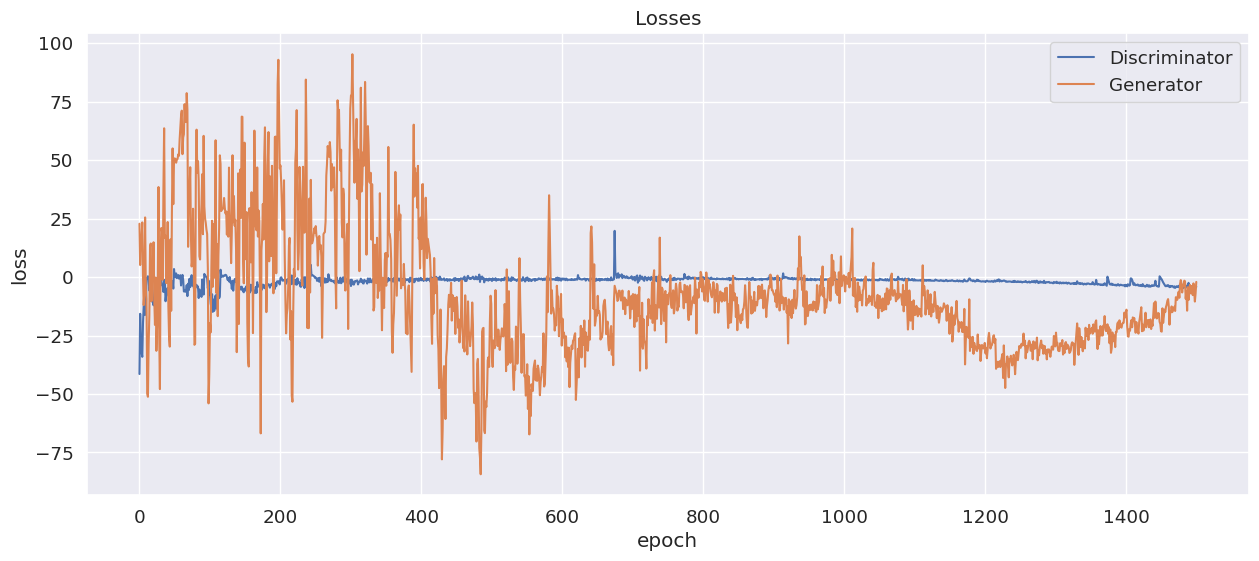

In [37]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, "-")
plt.plot(losses_g, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses")

## Explore new pokemons

In [85]:
n_images = 64

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [86]:
def show_images(generated):
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm_image(generated.cpu().detach()), nrow=8).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


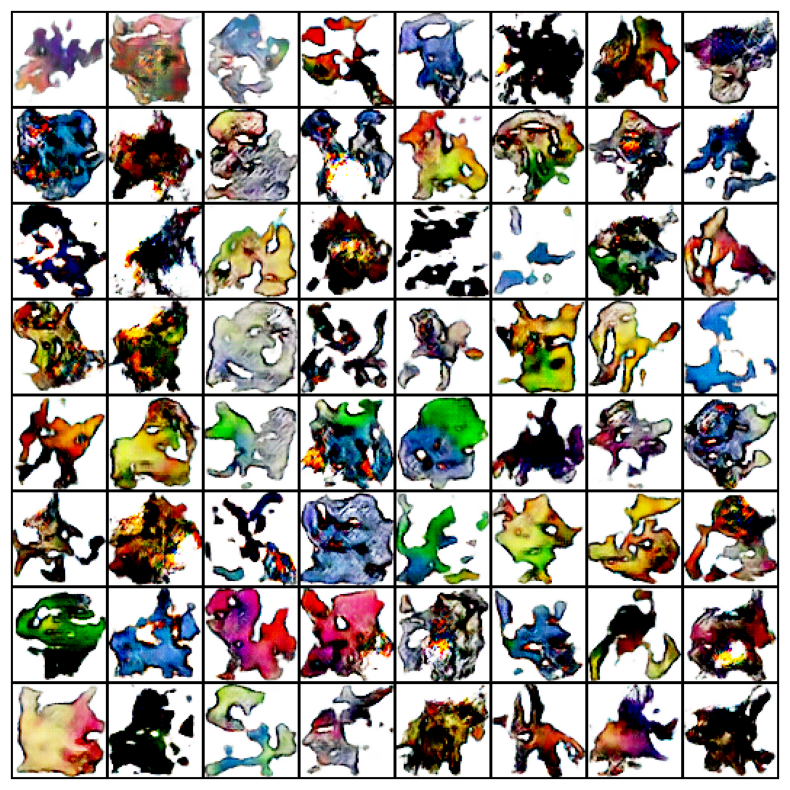

In [87]:
show_images(fake_images)

*Вывод:* вариант GAN'a с использованием расстояния Васерштейна был обучен на 1500 эпохах. В целом, он сходится лучше, чем классический DCGAN. Здесь нет mode collapse'a, картинки получаются разными, у них четкие границы. У получившихся покемонов иногда присутствуют детали, такие как уши, глаза, рот и т.д. При большем количестве эпох и данных могло бы получиться лучше.